In [1]:
from datetime import datetime, timedelta
import intake

import matplotlib.pyplot as plt

cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/catalog.yaml")


In [2]:
# --- SURFACE WEATHER STATION
wxt = cat.BCO.surfacemet_wxt_v1.to_dask()
wxt = wxt #.sel(time=slice('2015-01-01','2024-12-31'))  #sel(time=slice(datetime(year=2020, month=2, day=1, hour=0, minute=0), datetime(year=2020, month=3, day=1, hour=0, minute=0)) ) #slice(datetime.now() - timedelta(days=5), datetime.now())) #.plot(figsize=(12, 4));
wxt

# --- things I will need later
cp = 1004   # J / Kg K
Lv = 2.5e6  # J / Kg
grav  = 9.81   # m / s^2

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [3]:
vel  = wxt['VEL']
temp = wxt['T'] + 273.15  ## deg K
rh   = wxt['RH']/100.     ## values betwen 0 and 1
prec = wxt['R']

sfc_pressure = wxt['P']   ## already in hPa
from functions_collector import mr_from_rh

# temp is already in Kelvin
# press is already in mb
# rh was converted between 0 nd 1
q = mr_from_rh(temp, sfc_pressure, rh)

In [4]:
import xarray as xr
import numpy as np

# align to common time coordinate
# THIS IS MAGIC
temp, rh, q, vel, prec = xr.align(temp, rh, q, vel, prec, join="inner")

valid_mask = temp.notnull() & rh.notnull() & q.notnull() & vel.notnull() & prec.notnull()

vel  =  xr.where(valid_mask,  vel , np.nan)     
temp =  xr.where(valid_mask, temp , np.nan)       
rh   =  xr.where(valid_mask, rh , np.nan)       
q    =  xr.where(valid_mask,  q,   np.nan)      


# ---- compute a crude version of surface MSE
# ---- this should be a good estimator of the BL MSE
# ---- better estimates should be retrieved from Lidar
# cp = 1004   # J / Kg K
# Lv = 2.5e6  # J / Kg
# mse_sfc = cp*temp + Lv*q

prec =  xr.where(valid_mask, prec  , np.nan)    

common_times = prec.dropna(dim="time").time


print(f'VEL and Temp have same number of Nans now  : {vel.isnull().sum().values == temp.isnull().sum().values}')
print(f'Temp and Prec have same number of Nans now : {prec.isnull().sum().values == temp.isnull().sum().values}')

VEL and Temp have same number of Nans now  : True
Temp and Prec have same number of Nans now : True


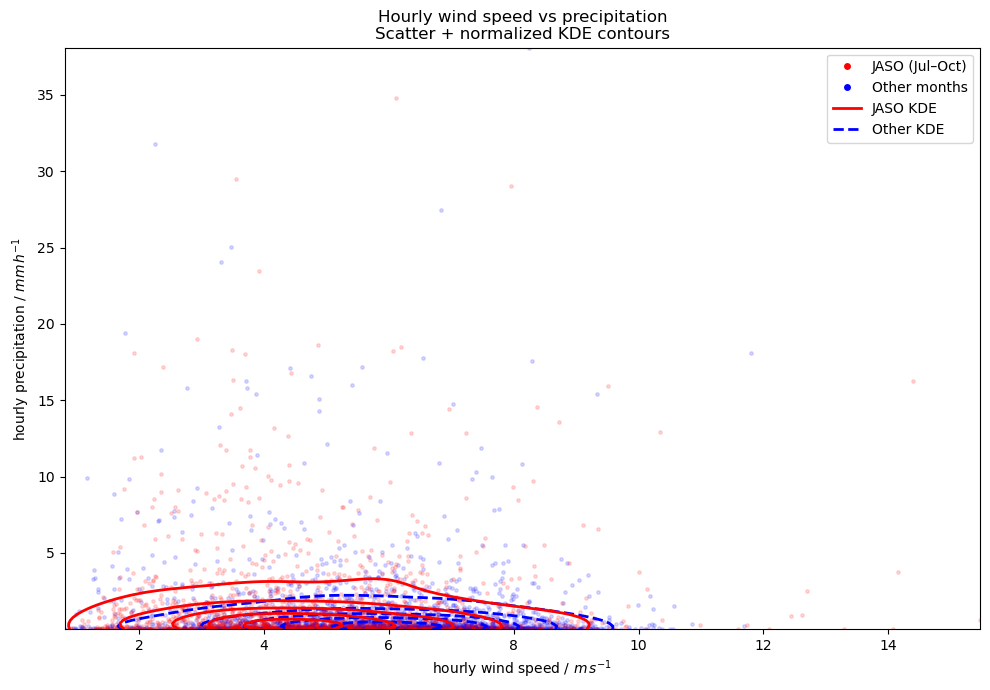

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.lines import Line2D

# -------------------------------
# Masks
# -------------------------------
months = hourly_precip['time'].dt.month.values
precip_mask = hourly_precip.values >= 0.01

jaso_mask  = np.isin(months, [7, 8, 9, 10]) & precip_mask
other_mask = ~np.isin(months, [7, 8, 9, 10]) & precip_mask

# -------------------------------
# Data
# -------------------------------
x_j = hourly_vel.values[jaso_mask]
y_j = hourly_precip.values[jaso_mask]

x_o = hourly_vel.values[other_mask]
y_o = hourly_precip.values[other_mask]

# -------------------------------
# Scatter plot
# -------------------------------
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(
    x_o, y_o,
    s=6,
    color='blue',
    alpha=0.15,
    rasterized=True,
    label='Other months'
)

ax.scatter(
    x_j, y_j,
    s=6,
    color='red',
    alpha=0.15,
    rasterized=True,
    label='JASO (Jul–Oct)'
)

# -------------------------------
# Common grid for KDE
# -------------------------------
xmin = min(x_j.min(), x_o.min())
xmax = max(x_j.max(), x_o.max())
ymin = min(y_j.min(), y_o.min())
ymax = max(y_j.max(), y_o.max())

xx, yy = np.meshgrid(
    np.linspace(xmin, xmax, 200),
    np.linspace(ymin, ymax, 200)
)

grid = np.vstack([xx.ravel(), yy.ravel()])

# -------------------------------
# KDE + normalization
# -------------------------------
kde_j = gaussian_kde(np.vstack([x_j, y_j]))
kde_o = gaussian_kde(np.vstack([x_o, y_o]))

zz_j = kde_j(grid).reshape(xx.shape)
zz_o = kde_o(grid).reshape(xx.shape)

zz_j /= zz_j.max()
zz_o /= zz_o.max()

# -------------------------------
# Density contours
# -------------------------------
levels = [0.1, 0.3, 0.5, 0.7, 0.9]

ax.contour(
    xx, yy, zz_o,
    levels=levels,
    colors='blue',
    linewidths=2,
    linestyles='dashed'
)

ax.contour(
    xx, yy, zz_j,
    levels=levels,
    colors='red',
    linewidths=2
)

# -------------------------------
# Labels & legend
# -------------------------------
ax.set_title('Hourly wind speed vs precipitation\nScatter + normalized KDE contours')
ax.set_xlabel(r'hourly wind speed / $m\,s^{-1}$')
ax.set_ylabel(r'hourly precipitation / $mm\,h^{-1}$')

legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='red', markersize=6,
           label='JASO (Jul–Oct)'),
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='blue', markersize=6,
           label='Other months'),
    Line2D([0], [0], color='red', lw=2, label='JASO KDE'),
    Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Other KDE')
]

ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()


In [5]:
## SELECT CONTINUOUS TIME SERIES OF Non-Nans

import pandas as pd
from scipy.ndimage import gaussian_filter1d
from functions_collector import gaussian_filter_nan



mask = vel.notnull()
mask = mask.to_pandas()

# ---- this ensures the mask is 1D
if isinstance(mask, pd.DataFrame):
    mask = mask.squeeze()

# ---- Step 2: Identify contiguous groups
group_id = (mask != mask.shift()).cumsum()

cleanSeries = []
for g, group in mask.groupby(group_id):
    if group.iloc[0]:  # True segment
        start = group.index[0]
        end = group.index[-1]
        duration = end - start
        duration_hr = pd.Timedelta(duration) / pd.Timedelta(hours=1)
        event_wind = vel.sel(time=slice(start, end))
        cleanSeries.append({"start": start,\
                       "end": end, \
                       "duration_hr": duration_hr, \
                       }
                           )


cleanSeries_df = pd.DataFrame(cleanSeries).sort_values(by="duration_hr", ascending=False).reset_index(drop=True)
cleanSeries_df


start                 end   duration_hr
0    2018-05-09 22:54:20 2021-04-11 04:19:10  25613.413889
1    2010-12-16 16:24:00 2012-11-14 20:50:30  16780.441667
2    2023-05-06 19:00:40 2024-12-09 17:30:00  13990.488889
3    2012-11-14 20:50:50 2013-11-08 17:45:10   8612.905556
4    2013-11-23 19:05:40 2014-09-21 16:37:50   7245.536111
...                  ...                 ...           ...
2541 2023-04-25 09:53:40 2023-04-25 09:53:40      0.000000
2542 2023-04-25 09:51:50 2023-04-25 09:51:50      0.000000
2543 2023-04-25 09:47:10 2023-04-25 09:47:10      0.000000
2544 2023-04-27 15:24:10 2023-04-27 15:24:10      0.000000
2545 2023-04-27 15:22:10 2023-04-27 15:22:10      0.000000

[2546 rows x 3 columns]

In [6]:
# --- from Bjorn's suggestion, draw pdf of wind speed in JASO
intervals = cleanSeries_df.loc[:40, ["start", "end"]]   # rows 0,1,2

import numpy as np
import xarray as xr

# - here I concatenate the longest time series together
time = vel.time  # all datasets share the same time coordinate
ASO = [7,8,9,10]

mask = np.zeros(time.size, dtype=bool)
for _, row in intervals.iterrows():
    mask |= (time >= row["start"]) & (time <= row["end"])


vel_sel  = vel.sel(time=time[mask])
temp_sel = temp.sel(time=time[mask])
q_sel    = q.sel(time=time[mask])
prec_sel = prec.sel(time=time[mask])


##### draw again the climatology plots

In [19]:
month_mse.month

<xarray.DataArray 'month' (month: 12)> Size: 96B
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    alt      float64 8B 29.0
    lat      float64 8B 13.16
    lon      float64 8B -59.43

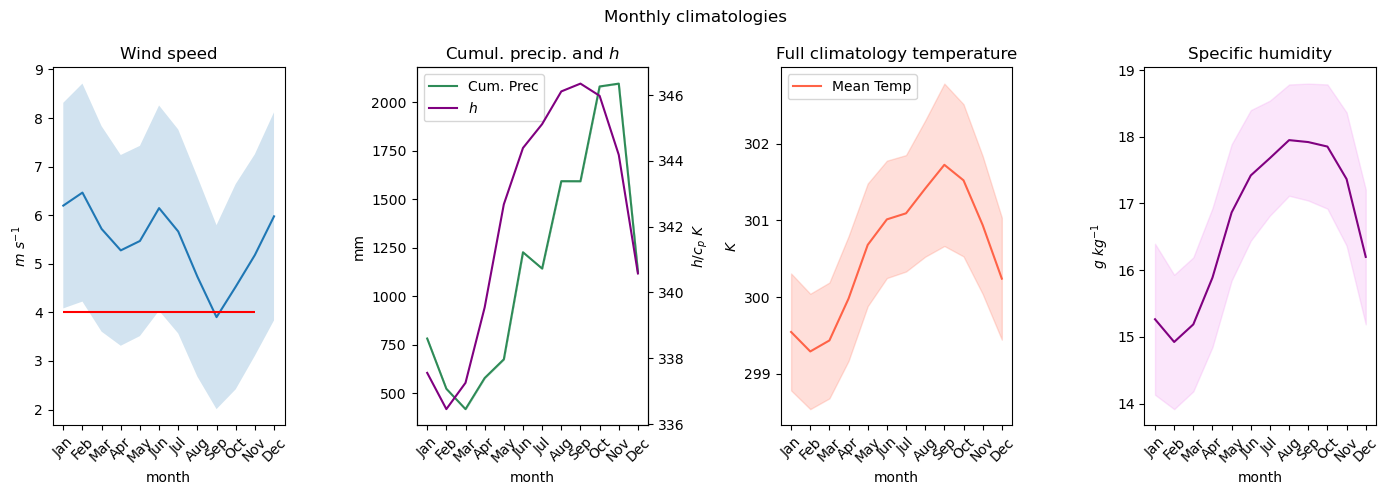

In [20]:
fig, ax = plt.subplots(1,4, figsize=(14,5))
import calendar
fig.suptitle("Monthly climatologies")

# Set month ticks (1–12)


# Use abbreviated month names
# ax[1,0].set_xticklabels(calendar.month_abbr[1:])  # ['Jan', 'Feb', ..., 'Dec']

###########  wind speed  #############
month_vel = vel_sel.groupby('time.month').mean(skipna=True)
month_std = vel_sel.groupby('time.month').std(skipna=True)

month_vel.plot(ax=ax[0])
ax[0].fill_between(month_vel.month, month_vel.values - month_std.values, month_vel.values + month_std.values, alpha=0.2)
ax[0].hlines(y=4.0, color='red', xmin=1, xmax=11)

ax[0].set_title('Wind speed')
ax[0].set_ylabel(r'$m~s^{-1}$')



############  preci  ###########
month_prec = prec_sel.groupby('time.month').sum(skipna=True)
std_prec   = prec_sel.groupby('time.month').std(skipna=True)

# xarray plot → returns a list of Line2D objects
p = month_prec.plot(ax=ax[1], color='seagreen', label='Cum. Prec')
l1 = p[0]   # grab the Line2D handle

ax[1].fill_between(
    month_prec.month,
    month_prec.values - std_prec.values,
    month_prec.values + std_prec.values,
    alpha=0.2, color='seagreen'
)

ax[1].set_ylabel(r'mm')

# --- MSE ---
month_mse = (cp*temp_sel + Lv*q_sel).groupby('time.month').mean(skipna=True)

twin_ax = ax[1].twinx()
l2, = twin_ax.plot(month_mse.month, month_mse / cp, color='purple', label=r"$h$")
twin_ax.set_ylabel(r'$h/c_p$ $K$')

ax[1].set_title(r'Cumul. precip. and $h$')

# ---- combined legend ----
ax[1].legend([l1, l2], ['Cum. Prec', r'$h$'], loc='best')






###########   temperature   ###########
month_temp = temp_sel.groupby('time.month').mean(skipna=True)
std_temp   = temp_sel.groupby('time.month').std(skipna=True)

month_temp.plot(ax=ax[2], color='tomato', label='Mean Temp')
ax[2].fill_between(month_temp.month,
                   month_temp.values - std_temp.values,
                   month_temp.values + std_temp.values,
                   alpha=0.2, color='tomato')
ax[2].set_title('Full climatology temperature')
ax[2].set_ylabel(r'$K$')
ax[2].legend()




########## specifci humidity  ########
month_q   = q_sel.groupby('time.month').mean(skipna=True)
std_q     = q_sel.groupby('time.month').std(skipna=True)

(1e3*month_q).plot(ax=ax[3], color='purple')
ax[3].fill_between(month_q.month, 1e3*(month_q.values - std_q.values), 1e3*(month_q.values + std_q.values), alpha=0.2, color='violet')
ax[3].set_ylabel(r'$g~kg^{-1}$')
ax[3].set_title('Specific humidity')



#### full mse #####
# month_mse   = (cp*temp_sel+Lv*q_sel).groupby('time.month').mean(skipna=True)
# std_mse     = (cp*temp_sel+Lv*q_sel).groupby('time.month').std(skipna=True)

# (month_mse/1e3).plot(ax=ax[0,4], color='purple')
# ax[0,4].fill_between(month_mse.month, (month_mse.values - std_mse.values)/1e3, (month_mse.values + std_mse.values)/1e3, alpha=0.2, color='violet')

# ax[0,4].set_title('Full climatology MSE')




##### cleaning xaxes #####
month_names = calendar.month_abbr[1:]  # ['Jan', 'Feb', ..., 'Dec']

# Loop over all columns
for i in range(ax.shape[0]):
    # --- Bottom row (show month names) ---
    ax[i].set_xticks(range(1, 13))
    ax[i].set_xticklabels(month_names, rotation=45)
    # ax[0, i].set_xlabel('Month')

plt.tight_layout()

In [8]:
def weighted_pdf(x,weight):

    ## inputs: 
    ## x,y Xarrays with ALIGNED TIME DIMENSION
    percentiles = xr.DataArray(np.arange(0,1.05,0.05))
    bins_x = x.quantile(percentiles).values

    # total precip per wind-speed bin
    weight_per_bin_ws = weight.groupby_bins(x, bins=bins_x).sum()

    # bin widths
    bin_widths = xr.DataArray(
        np.diff(bins_x),
        dims=weight_per_bin_ws.dims
    )

    # normalize → PDF
    pdf_x = weight_per_bin_ws / (weight_per_bin_ws.sum() * bin_widths)

    # bin centers
    centers_x = 0.5 * (bins_x[:-1] + bins_x[1:])

    return centers_x, pdf_x

In [10]:
# # - data selection
x_vel = vel_sel.resample(time="1h").mean()
y_mse = (cp * temp_sel + Lv * q_sel).resample(time="1h").mean()
z_prec = prec_sel.resample(time='1h').sum()

In [ ]:
x_vel_ASO = x_vel.where(x_vel.time.dt.month.isin(ASO), drop=True)
z_prec_ASO = z_prec.where(z_prec.time.dt.month.isin(ASO), drop=True)

x_vel_notASO = x_vel.where(~x_vel.time.dt.month.isin(ASO), drop=True)
z_prec_notASO = z_prec.where(~z_prec.time.dt.month.isin(ASO), drop=True)


## - plotting

fig, ax = plt.subplots(1,1)

v, p = xr.align(x_vel_ASO, z_prec_ASO)
centers_v, pdf_v = weighted_pdf(v,p)

ax.plot(centers_v, pdf_v, "blue", label="JASO weight")
ax.hist(v, bins=30, histtype="step", density=True, color="tab:blue", label="JASO no weight")



v, p = xr.align(x_vel_notASO, z_prec_notASO)
centers_v, pdf_v = weighted_pdf(v,p)

ax.plot(centers_v, pdf_v, "red", label="non JASO, weight")
ax.hist(v, bins=30, histtype="step", density=True, color="tab:red", label="no JASO no weight")


for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

ax.set_ylabel("density")
ax.set_xlabel(r"hourly wind / $m~s^{-1}$")

ax.legend()
plt.show()

idea: compute MSE at the surface and link it to precipitation and wind speed

in a well-mixed BL, the sfc MSE should provide a good estimate of the depth-avg MSE content \newline
the estimate here carries the following uncertainties:
      

   * instrumental uncertainties (provided in the dataset)
   * land-related processes

X axis = hourly MSE
Y axis = hourly wind
colormap = intensity of hourly cumulated precipitation

In [16]:
# --- select clan time series to work with
time_sel = slice(cleanSeries_df.loc[0]["start"], cleanSeries_df.loc[0]["end"])

threshold = 4.
hourly_vel    = vel.sel(time=time_sel).resample(time='1d').mean()
hourly_mse    = (cp*temp.sel(time=time_sel) + Lv*q.sel(time=time_sel)).resample(time='1d').mean()

hourly_precip = prec.sel(time=time_sel).resample(time='1d').sum()
precip_mask   = hourly_precip.values >= 0.1
dry_mask      = hourly_precip.values < 0.1


# ---- plotting here

fig, ax = plt.subplots(1,3, figsize=(15,5))
from mpl_toolkits.axes_grid1 import make_axes_locatable


scatt = ax[0].hexbin( hourly_vel[precip_mask],\
                      hourly_precip[precip_mask],
                      mincnt=1.,\
                      gridsize=(70,40),\
                      cmap="inferno" )

ax[0].set_title('Instantaneous corr. vel vs preci')
ax[0].set_xlabel(f'daily mean wind speed / m/s')
ax[0].set_ylabel('daily cumulated precipitation / mm')
ax[0].vlines(x=threshold, ymin=0, ymax=30, color="red", linestyle="--")


# - rainy hours only

scatt2 = ax[1].hexbin(hourly_vel[precip_mask],\
                      hourly_mse[precip_mask]/1e3,\
                      mincnt=1.,\
                      gridsize=(70,40),\
                      cmap="viridis" )

plt.colorbar(scatt2, ax=ax[1], label="counts")
ax[1].set_title('Wind speed and MSE vs preci - WET')
ax[1].set_xlabel(f'daily mean wind speed / m/s')
ax[1].set_ylabel('daily MSE / kJ/kg')
ax[1].vlines(x=threshold, ymin=337, ymax=352, color="red", linestyle="--")
ax[1].set_ylim([335, 355]) 
ax[1].set_xlim([1, 10])

# - dry hours only

scatt3 = ax[2].hexbin(hourly_vel[dry_mask],\
                      hourly_mse[dry_mask]/1e3,\
                      mincnt=1.,\
                      gridsize=(70,40),\
                      cmap="viridis" )

plt.colorbar(scatt3, ax=ax[2], label="counts")
ax[2].set_title('Wind speed and MSE vs preci - DRY')
ax[2].set_xlabel(f'daily mean wind speed / m/s')
ax[2].set_ylabel('daily MSE / kJ/kg')
ax[2].vlines(x=threshold, ymin=337, ymax=352, color="red", linestyle="--")
ax[2].set_ylim([335, 355])
ax[2].set_xlim([1, 10])

plt.tight_layout()

In [29]:
# --- from Cathy's suggestion, identify seasonal clusters!
intervals = cleanSeries_df.loc[:10, ["start", "end"]]   # rows 0,1,2

import numpy as np
import xarray as xr

# - here I concatenate the longest time series together
time = vel.time  # all datasets share the same time coordinate
ASO = [7,8,9,10]

mask = np.zeros(time.size, dtype=bool)
for _, row in intervals.iterrows():
    mask |= (time >= row["start"]) & (time <= row["end"])


vel_sel  = vel.sel(time=time[mask])
temp_sel = temp.sel(time=time[mask])
q_sel    = q.sel(time=time[mask])
prec_sel = prec.sel(time=time[mask])

# - data selection
x_vel = vel_sel.resample(time="1h").mean()
y_mse = (cp * temp_sel + Lv * q_sel).resample(time="1h").mean()
z_prec = prec_sel.resample(time='1h').sum()

x_vel_ASO = x_vel.where(x_vel.time.dt.month.isin(ASO), drop=True)
y_mse_ASO = y_mse.where(y_mse.time.dt.month.isin(ASO), drop=True)
z_prec_ASO = z_prec.where(z_prec.time.dt.month.isin(ASO), drop=True)

x_vel_notASO = x_vel.where(~x_vel.time.dt.month.isin(ASO), drop=True)
y_mse_notASO = y_mse.where(~y_mse.time.dt.month.isin(ASO), drop=True)
z_prec_notASO = z_prec.where(~z_prec.time.dt.month.isin(ASO), drop=True)




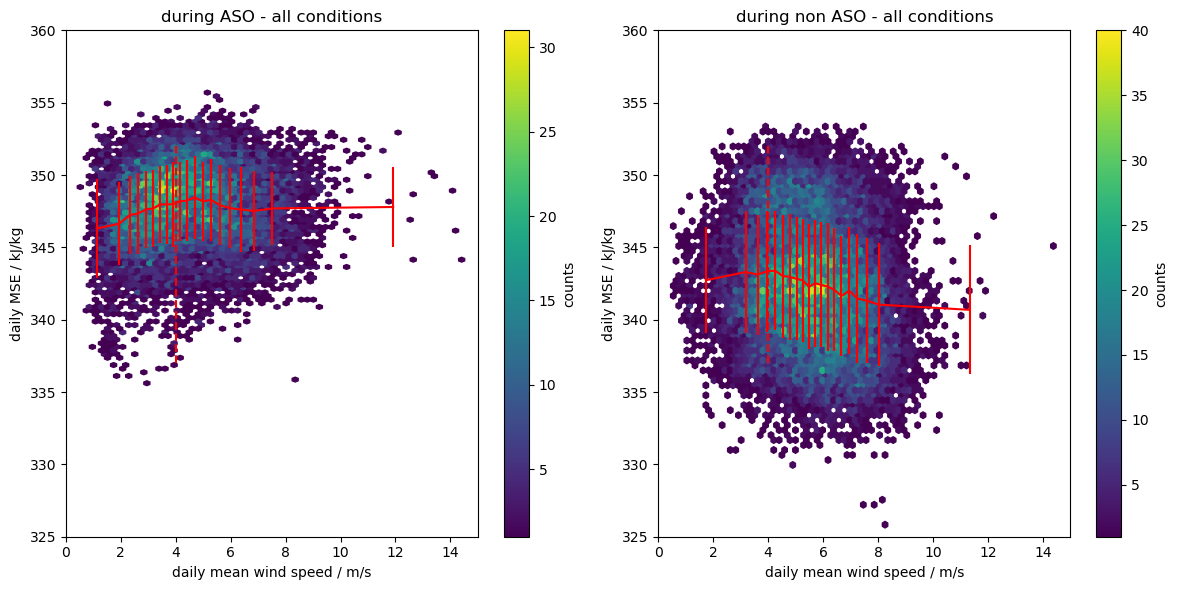

In [59]:
# - plotting ASO vs non ASO
seasons = ["ASO", "rest of year"]
threshold = 4.
fig, ax = plt.subplots(1,2, figsize=(12,6))
# ax = ax.flatten()


scatt = ax[0].hexbin(x_vel_ASO,\
                    y_mse_ASO/1e3,\
                    mincnt=1.,\
                    gridsize=(70,40),\
                    cmap="viridis" )

plt.colorbar(scatt, ax=ax[0], label="counts")
ax[0].set_title('during ASO - all conditions')
ax[0].set_xlabel(f'daily mean wind speed / m/s')
ax[0].set_ylabel('daily MSE / kJ/kg')
ax[0].vlines(x=threshold, ymin=337, ymax=352, color="red", linestyle="--")
ax[0].set_ylim([325, 360])
ax[0].set_xlim([0, 15])


### - compute some statistics
x = x_vel_ASO
y = y_mse_ASO/1e3
                    
percentiles = xr.DataArray(np.arange(0,1.05,0.05))
bin_edges = x.quantile(percentiles).values
bin_centroids = 0.5*(bin_edges[:-1] + bin_edges[1:])

grouped = y.groupby_bins(x, bins=bin_edges)

ax[0].errorbar(bin_centroids, grouped.mean(), 
               yerr = grouped.std(), 
               color = "red")




scatt = ax[1].hexbin(x_vel_notASO,\
                    y_mse_notASO/1e3,\
                    mincnt=1.,\
                    gridsize=(70,40),\
                    cmap="viridis" )

plt.colorbar(scatt, ax=ax[1], label="counts")
ax[1].set_title('during non ASO - all conditions')
ax[1].set_xlabel(f'daily mean wind speed / m/s')
ax[1].set_ylabel('daily MSE / kJ/kg')
ax[1].vlines(x=threshold, ymin=337, ymax=352, color="red", linestyle="--")
ax[1].set_ylim([325, 360])
ax[1].set_xlim([0, 15])

x = x_vel_notASO
y = y_mse_notASO/1e3
                    
bin_edges = x.quantile(percentiles).values
bin_centroids = 0.5*(bin_edges[:-1] + bin_edges[1:])

grouped = y.groupby_bins(x, bins=bin_edges)

ax[1].errorbar(bin_centroids, grouped.mean(), 
               yerr = grouped.std(), 
               color = "red")

plt.tight_layout()

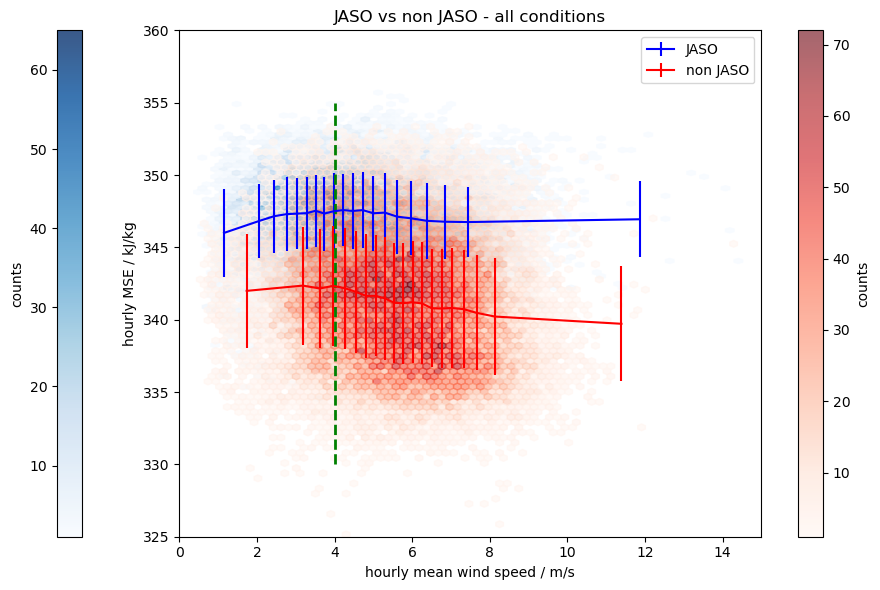

In [30]:
# - plotting ASO vs non ASO
seasons = ["ASO", "rest of year"]
threshold = 4.
fig, ax = plt.subplots(1,1, figsize=(10,6))
# ax = ax.flatten()


scatt = ax.hexbin(x_vel_ASO,\
                    y_mse_ASO/1e3,\
                    mincnt=1.,\
                    gridsize=(70,40),\
                    cmap="Blues" , alpha=0.8)

plt.colorbar(scatt, ax=ax, label="counts", location="left")


### - compute some statistics
x = x_vel_ASO
y = y_mse_ASO/1e3
                    
percentiles = xr.DataArray(np.arange(0,1.05,0.05))
bin_edges = x.quantile(percentiles).values
bin_centroids = 0.5*(bin_edges[:-1] + bin_edges[1:])

grouped = y.groupby_bins(x, bins=bin_edges)

ax.errorbar(bin_centroids, grouped.mean(), 
               yerr = grouped.std(), 
               color = "blue", label="JASO")




scatt = ax.hexbin(x_vel_notASO,\
                    y_mse_notASO/1e3,\
                    mincnt=1.,\
                    gridsize=(70,40),\
                    cmap="Reds", alpha=0.6)

plt.colorbar(scatt, ax=ax, label="counts")


x = x_vel_notASO
y = y_mse_notASO/1e3
                    
bin_edges = x.quantile(percentiles).values
bin_centroids = 0.5*(bin_edges[:-1] + bin_edges[1:])

grouped = y.groupby_bins(x, bins=bin_edges)

ax.errorbar(bin_centroids, grouped.mean(), 
               yerr = grouped.std(), 
               color = "red", label="non JASO")



# - explaining the plot
ax.vlines(x=threshold, ymin=330, ymax=355, color="green", linestyle="--", linewidth=2)
ax.set_title('JASO vs non JASO - all conditions')
ax.set_xlabel(f'hourly mean wind speed / m/s')
ax.set_ylabel('hourly MSE / kJ/kg')
ax.set_ylim([325, 360])
ax.set_xlim([0, 15])
ax.legend()

plt.tight_layout()

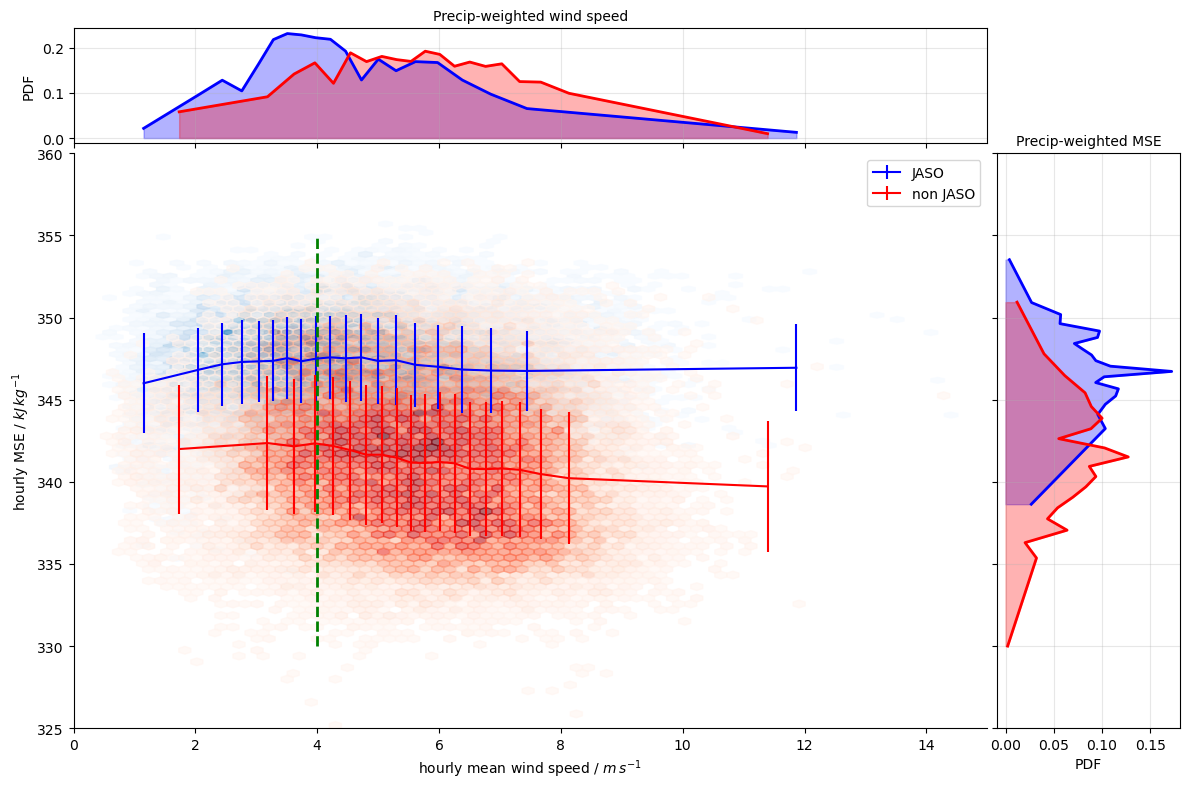

In [31]:
# - plotting ASO vs non ASO
seasons = ["ASO", "rest of year"]
threshold = 4.
fig, ax = plt.subplots(1,1, figsize=(12,8))
# ax = ax.flatten()


scatt = ax.hexbin(x_vel_ASO,\
                  y_mse_ASO/1e3,\
                    mincnt=1.,\
                    gridsize=(70,40),\
                    cmap="Blues" , alpha=0.8)

# plt.colorbar(scatt, ax=ax, label="counts", location="left")


### - compute some statistics
x = x_vel_ASO
y = y_mse_ASO/1e3
                    
percentiles = xr.DataArray(np.arange(0,1.05,0.05))
bin_edges = x.quantile(percentiles).values
bin_centroids = 0.5*(bin_edges[:-1] + bin_edges[1:])

grouped = y.groupby_bins(x, bins=bin_edges)

ax.errorbar(bin_centroids, grouped.mean(), 
               yerr = grouped.std(), 
               color = "blue", label="JASO")




scatt = ax.hexbin(x_vel_notASO,\
                    y_mse_notASO/1e3,\
                    mincnt=1.,\
                    gridsize=(70,40),\
                    cmap="Reds", alpha=0.6)

# plt.colorbar(scatt, ax=ax, label="counts")


x = x_vel_notASO
y = y_mse_notASO/1e3
                    
bin_edges = x.quantile(percentiles).values
bin_centroids = 0.5*(bin_edges[:-1] + bin_edges[1:])

grouped = y.groupby_bins(x, bins=bin_edges)

ax.errorbar(bin_centroids, grouped.mean(), 
               yerr = grouped.std(), 
               color = "red", label="non JASO")



# - explaining the plot
ax.vlines(x=threshold, ymin=330, ymax=355, color="green", linestyle="--", linewidth=2)
# ax.set_title('JASO vs non JASO - all conditions')
ax.set_xlabel(r'hourly mean wind speed / $m\,s^{-1}$')
ax.set_ylabel(r'hourly MSE / $kJ\,kg^{-1}$')
ax.set_ylim([325, 360])
ax.set_xlim([0, 15])
ax.legend()



## --- adding weighted pdfs
from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(ax)

ax_top   = divider.append_axes("top",   size="20%", pad=0.1, sharex=ax)
ax_right = divider.append_axes("right", size="20%", pad=0.1, sharey=ax)

# hide tick labels where appropriate
plt.setp(ax_top.get_xticklabels(), visible=False)
plt.setp(ax_right.get_yticklabels(), visible=False)

#################   JASO    ###############
## - wind speed
# align arrays
x, p = xr.align(x_vel_ASO, z_prec_ASO)

# bins_x = np.linspace(0, 15, 60)

percentiles = xr.DataArray(np.arange(0,1.05,0.05))
bins_x = x.quantile(percentiles).values

# total precip per wind-speed bin
precip_per_bin_ws = p.groupby_bins(x, bins=bins_x).sum()

# bin widths
bin_widths = xr.DataArray(
    np.diff(bins_x),
    dims=precip_per_bin_ws.dims
)

# normalize → PDF
pdf_x = precip_per_bin_ws / (precip_per_bin_ws.sum() * bin_widths)

# bin centers
centers_x = 0.5 * (bins_x[:-1] + bins_x[1:])

ax_top.plot(centers_x, pdf_x.compute(), color="blue", lw=2)
ax_top.fill_between(centers_x, pdf_x.compute(), color="blue", alpha=0.3)




## - MSE
y, p = xr.align(y_mse_ASO / 1e3, z_prec_ASO)

# bins_y = np.linspace(325, 360, 60)
bins_y = y.quantile(percentiles).values

precip_per_bin_mse = p.groupby_bins(y, bins=bins_y).sum()
bin_widths = xr.DataArray(
    np.diff(bins_y),
    dims=precip_per_bin_mse.dims
)

pdf_y = precip_per_bin_mse / (precip_per_bin_mse.sum() * bin_widths)
centers_y = 0.5 * (bins_y[:-1] + bins_y[1:])

ax_right.plot(pdf_y.compute(), centers_y, color="blue", lw=2)
ax_right.fill_betweenx(centers_y, pdf_y.compute(), color="blue", alpha=0.3)




##################    non JASO    ####################
## - wind speed
# align arrays
x, p = xr.align(x_vel_notASO, z_prec_notASO)

# bins_x = np.linspace(0, 15, 60)
bins_x = x.quantile(percentiles).values

# total precip per wind-speed bin
precip_per_bin_ws = p.groupby_bins(x, bins=bins_x).sum()

# bin widths
bin_widths = xr.DataArray(
    np.diff(bins_x),
    dims=precip_per_bin_ws.dims
)

# normalize → PDF
pdf_x = precip_per_bin_ws / (precip_per_bin_ws.sum() * bin_widths)

# bin centers
centers_x = 0.5 * (bins_x[:-1] + bins_x[1:])

ax_top.plot(centers_x, pdf_x.compute(), color="red", lw=2)
ax_top.fill_between(centers_x, pdf_x.compute(), color="red", alpha=0.3)




## - MSE
y, p = xr.align(y_mse_notASO / 1e3, z_prec_notASO)

# bins_y = np.linspace(325, 360, 60)
bins_y = y.quantile(percentiles).values

precip_per_bin_mse = p.groupby_bins(y, bins=bins_y).sum()
bin_widths = xr.DataArray(
    np.diff(bins_y),
    dims=precip_per_bin_mse.dims
)

pdf_y = precip_per_bin_mse / (precip_per_bin_mse.sum() * bin_widths)
centers_y = 0.5 * (bins_y[:-1] + bins_y[1:])

ax_right.plot(pdf_y.compute(), centers_y, color="red", lw=2)
ax_right.fill_betweenx(centers_y, pdf_y.compute(), color="red", alpha=0.3)



ax_top.set_xlim(ax.get_xlim())
ax_right.set_ylim(ax.get_ylim())

ax_top.grid(alpha=0.3)
ax_right.grid(alpha=0.3)


## naming axes
ax_top.set_title("Precip-weighted wind speed", fontsize=10, pad=6)
ax_top.set_ylabel("PDF")

ax_right.set_title("Precip-weighted MSE", fontsize=10, pad=6)
ax_right.set_xlabel("PDF")


for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

plt.tight_layout()

#### draw pdf of wind speed in JASO for the years available

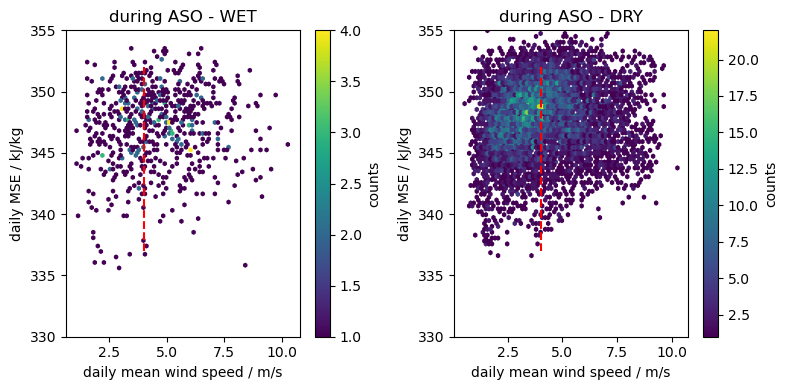

In [33]:
fig, ax = plt.subplots(1,2, figsize=(8,4))

precip_mask   = z_prec_ASO.values >= 0.1
dry_mask      = z_prec_ASO.values <  0.1


scatt = ax[0].hexbin(x_vel_ASO[precip_mask],\
                    y_mse_ASO[precip_mask]/1e3,\
                    mincnt=1.,\
                    gridsize=(70,40),\
                    cmap="viridis" )

plt.colorbar(scatt, ax=ax[0], label="counts")
ax[0].set_title('during ASO - WET')
ax[0].set_xlabel(f'daily mean wind speed / m/s')
ax[0].set_ylabel('daily MSE / kJ/kg')
ax[0].vlines(x=threshold, ymin=337, ymax=352, color="red", linestyle="--")
ax[0].set_ylim([330, 355])




scatt = ax[1].hexbin(x_vel_ASO[dry_mask],\
                    y_mse_ASO[dry_mask]/1e3,\
                    mincnt=1.,\
                    gridsize=(70,40),\
                    cmap="viridis" )

plt.colorbar(scatt, ax=ax[1], label="counts")
ax[1].set_title('during ASO - DRY')
ax[1].set_xlabel(f'daily mean wind speed / m/s')
ax[1].set_ylabel('daily MSE / kJ/kg')
ax[1].vlines(x=threshold, ymin=337, ymax=352, color="red", linestyle="--")
ax[1].set_ylim([330, 355])


plt.tight_layout()

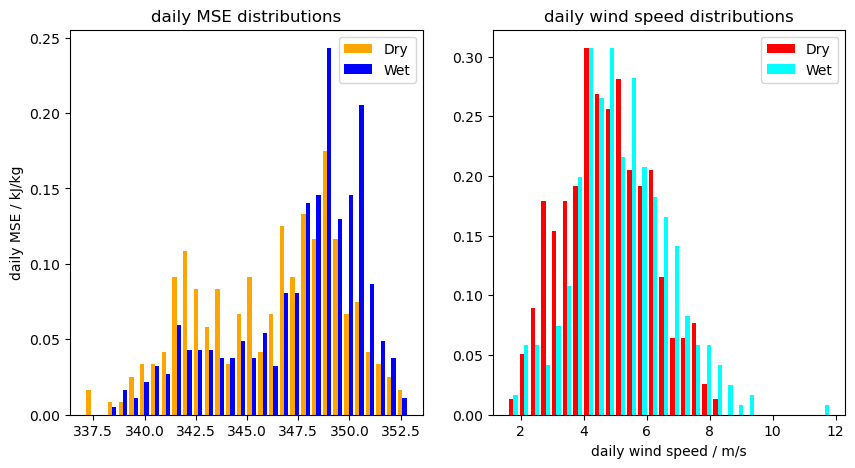

In [43]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].hist([hourly_mse[dry_mask]/1e3 , \
            hourly_mse[precip_mask]/1e3],\
            bins=30, histtype='bar',\
            color=['orange', 'blue'],
            density=True, 
            label=['Dry', 'Wet'])
ax[0].set_title("daily MSE distributions")
ax[0].legend()
ax[0].set_ylabel('daily MSE / kJ/kg')


ax[1].hist([hourly_vel[dry_mask],
            hourly_vel[precip_mask]],
            bins=30,
            histtype='bar', 
            color=['red', 'cyan'],
            density=True,
            label=['Dry', 'Wet'])
ax[1].set_title("daily wind speed distributions")
ax[1].set_xlabel(f'daily wind speed / m/s')
ax[1].legend()

plt.show()

In [42]:
MBR2 = cat.BCO.radar_MBR2_c4_v1.to_dask()
MBR2 = MBR2.sel(time=slice('2020-01-01','2024-12-31'))
MBR2

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 1TB
Dimensions:     (time: 41481055, alt: 605)
Coordinates:
  * time        (time) datetime64[ns] 332MB 2020-01-12T16:19:26 ... 2023-03-1...
  * alt         (alt) float64 5kB 174.4 205.6 236.8 ... 1.898e+04 1.901e+04
    lat         float64 8B ...
    lon         float64 8B ...
Data variables: (12/23)
    HSDco       (time, alt) float32 100GB dask.array<chunksize=(17239, 55), meta=np.ndarray>
    HSDcx       (time, alt) float32 100GB dask.array<chunksize=(17239, 55), meta=np.ndarray>
    LDR         (time, alt) float32 100GB dask.array<chunksize=(17239, 55), meta=np.ndarray>
    LDRg        (time, alt) float32 100GB dask.array<chunksize=(17239, 55), meta=np.ndarray>
    MeltHei     (time) float32 166MB dask.array<chunksize=(2090839,), meta=np.ndarray>
    RMS         (time, alt) float32 100GB dask.array<chunksize=(17239, 55), meta=np.ndarray>
    ...          ...
    mask        (time, alt) bool 25GB dask.array<chunksize=(17239, 55), meta=np.ndarray>
    northangle  (time) float32 166MB dask.array<chunksize=(2090839,), meta=np.ndarray>
    sensor_alt  float64 8B ...
    status      (time) int16 83MB dask.array<chunksize=(2090839,), meta=np.ndarray>
    tpow        (time) float32 166MB dask.array<chunksize=(2090839,), meta=np.ndarray>
    zenith      float64 8B ...
Attributes:
    Conventions:      CF-1.7
    bcoproc_version:  2.0.1.dev221+g18013fd
    created_with:     bcoproc (kband.py)
    creation_date:    Sat Mar 18 12:01:17 2023
    institution:      Max Planck Institute for Meteorology, Hamburg
    instrument:       MBR2 cloud radar
    location:         The Barbados Cloud Observatory, Deebles Point, Barbados...
    reference:        Ka Band Cloud Radar MIRA-3x, METEK GmbH www.metek.de
    system:           MIRA36
    title:            MIRA-3x Cloud Radar Data
    tool_versions:    {"Python": "3.10.6 | packaged by conda-forge | (main, A...

In [45]:
# ---- IDENTIFY LOW WIND SPEED EVENTS

import pandas as pd
from scipy.ndimage import gaussian_filter1d
from functions import gaussian_filter_nan

# --- low WS events parameters
threshold = 4.0
min_duration = pd.Timedelta("6h")


# --- smooth out the wind in the longest clean Timeseries
vel = vel.sel(time=slice(cleanSeries_df.loc[0]["start"], cleanSeries_df.loc[0]["end"])).chunk({'time': -1})
smooth_vel = xr.apply_ufunc(
        gaussian_filter_nan,
        vel,
        kwargs={'sigma': 180, 'axis': 0, 'truncate': 4.0},
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[vel.dtype]
    )

# ---- this ensures that the smoothed wind is built
# ---- in the same way as the series of the other vars
# smooth_vel = xr.where(valid_mask, smooth_vel, np.nan)


below = (smooth_vel < threshold)
mask = below.to_pandas()

# this ensures the mask is 1D
if isinstance(mask, pd.DataFrame):
    mask = mask.squeeze()

# --- Step 2: Identify contiguous groups ---
group_id = (mask != mask.shift()).cumsum()

events = []
for g, group in mask.groupby(group_id):
    if group.iloc[0]:  # True segment
        start = group.index[0]
        end = group.index[-1]
        duration = end - start
        if duration >= min_duration :
            duration_hr = pd.Timedelta(duration) / pd.Timedelta(hours=1)

            ## add all other data so as to have them unified in a single df

            events.append({"start": start,\
                           "end": end, \
                           "duration": duration,\
                           "duration_hr": duration_hr, \
                           "precipitation":prec.sel(time=slice(start, end)),\
                           "temperature":temp.sel(time=slice(start, end)),\
                           "specific humidity":q.sel(time=slice(start, end)),\
                           "wind":vel.sel(time=slice(start, end)),\
                           "LPwind":smooth_vel.sel(time=slice(start, end))
                           }
                           )


events_df = pd.DataFrame(events).sort_values(by="duration_hr", ascending=False).reset_index(drop=True)
events_df


start                 end        duration  duration_hr  \
0   2023-12-24 01:35:00 2023-12-29 00:11:10 4 days 22:36:10   118.602778   
1   2024-10-02 02:03:30 2024-10-05 14:34:20 3 days 12:30:50    84.513889   
2   2023-09-13 20:18:50 2023-09-17 02:03:20 3 days 05:44:30    77.741667   
3   2023-09-17 03:26:00 2023-09-20 01:06:00 2 days 21:40:00    69.666667   
4   2024-09-28 22:07:20 2024-10-01 08:11:20 2 days 10:04:00    58.066667   
..                  ...                 ...             ...          ...   
182 2023-10-04 19:12:50 2023-10-05 01:29:20 0 days 06:16:30     6.275000   
183 2023-10-08 04:43:50 2023-10-08 10:53:10 0 days 06:09:20     6.155556   
184 2023-10-22 17:21:40 2023-10-22 23:30:40 0 days 06:09:00     6.150000   
185 2024-08-25 12:47:20 2024-08-25 18:50:50 0 days 06:03:30     6.058333   
186 2024-09-25 09:44:30 2024-09-25 15:47:50 0 days 06:03:20     6.055556   

                                         precipitation  \
0    [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
1    [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
2    [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
3    [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
4    [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
..                                                 ...   
182  [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
183  [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
184  [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
185  [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
186  [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   

                                           temperature  \
0    [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
1    [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
2    [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
3    [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
4    [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
..                                                 ...   
182  [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
183  [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
184  [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
185  [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
186  [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   

                                     specific humidity  \
0    [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
1    [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
2    [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
3    [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
4    [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
..                                                 ...   
182  [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
183  [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
184  [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
185  [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
186  [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   

                                                  wind  \
0    [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
1    [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
2    [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
3    [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
4    [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
..                                                 ...   
182  [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
183  [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
184  [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
185  [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   
186  [<xarray.DataArray ()> Size: 4B\ndask.array<ge...   

                                                LPwind  
0    [<xarray.DataArray ()> Size: 4B\ndask.array<ge...  
1    [<xarray.DataArray ()> Size: 4B\ndask.array<ge...  
2    [<xarray.DataArray ()> Size: 4B\ndask.array<ge...  
3    [<xarray.DataArray ()> Size: 4B\ndask.array<ge...  
4    [<xarray.DataArray ()> Size

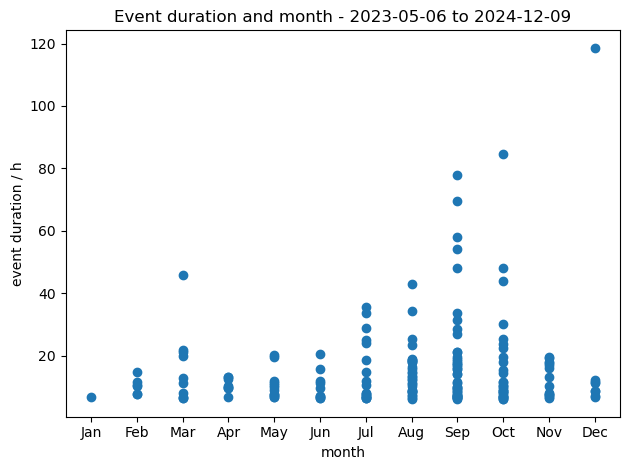

In [50]:
# ---- when do events happen and how long they last

fig, ax = plt.subplots(1,1)

ax.scatter(events_df["start"].dt.month.values, \
           events_df["duration_hr"].values)   

ax.set_title(
    f"Event duration and month - "
    f"{cleanSeries_df.loc[0, 'start'].strftime('%Y-%m-%d')} to "
    f"{cleanSeries_df.loc[0, 'end'].strftime('%Y-%m-%d')}"
)
ax.set_xlabel("month")
ax.set_ylabel("event duration / h")

ax.set_xticks(range(1, 13))
import calendar
ax.set_xticklabels(calendar.month_abbr[1:])

plt.tight_layout()

In [21]:
fig, ax = plt.subplots(2,5, figsize=(15,7))
import calendar

# Set month ticks (1–12)


# Use abbreviated month names
ax[1,0].set_xticklabels(calendar.month_abbr[1:])  # ['Jan', 'Feb', ..., 'Dec']

month_vel = wxt['VEL'].groupby('time.month').mean(skipna=True)
month_std = wxt['VEL'].groupby('time.month').std(skipna=True)
pop_vel   = wxt['VEL'].isnull().groupby('time.month').sum()

month_vel.plot(ax=ax[0,0])
ax[0,0].fill_between(month_vel.month, month_vel.values - month_std.values, month_vel.values + month_std.values, alpha=0.2)
ax[0,0].hlines(y=4.0, color='red', xmin=1, xmax=11)

ax[0,0].set_title('Full climatology wind speed')


ax[1,0].plot(month_vel.month, pop_vel)
ax[1,0].set_title('Nan values in each month')



###########   temperature   ###########
month_temp = temp.groupby('time.month').mean(skipna=True)
std_temp   = temp.groupby('time.month').std(skipna=True)
pop_temp   = temp.isnull().groupby('time.month').sum()

month_temp.plot(ax=ax[0,1], color='tomato', label='Mean Temp')
ax[0,1].fill_between(month_temp.month,
                   month_temp.values - std_temp.values,
                   month_temp.values + std_temp.values,
                   alpha=0.2, color='tomato')
ax[0,1].set_title('Full climatology temperature')
ax[0,1].set_ylabel('Temperature [K]')
ax[0,1].legend()

ax[1,1].plot(pop_temp.month, pop_temp.values, 'o-', color='darkorange')
ax[1,1].set_title('NaN values in each month')
ax[1,1].set_xlabel('Month')
ax[1,1].set_ylabel('# NaN')



############  RH  ###########
month_prec =prec.groupby('time.month').sum(skipna=True)
std_prec   =prec.groupby('time.month').std(skipna=True)
pop_prec   =prec.isnull().groupby('time.month').sum()

month_prec.plot(ax=ax[0,2], color='seagreen', label='Cum. Prec')
ax[0,2].fill_between(month_prec.month,
                   month_prec.values - std_prec.values,
                   month_prec.values + std_prec.values,
                   alpha=0.2, color='seagreen')
ax[0,2].set_title('Full climatology precip.')
ax[0,2].set_ylabel('Relative humidity [-]')
ax[0,2].legend()

ax[1,2].plot(pop_prec.month, pop_prec.values, 'o-', color='seagreen')
ax[1,2].set_title('NaN values in each month')
ax[1,2].set_xlabel('Month')
ax[1,2].set_ylabel('# NaN')



########## specifci humidity  ########
month_q   = q.groupby('time.month').mean(skipna=True)
std_q     = q.groupby('time.month').std(skipna=True)
pop_q     = q.isnull().groupby('time.month').sum()

(1e3*month_q).plot(ax=ax[0,3], color='purple')
ax[0,3].fill_between(month_q.month, 1e3*(month_q.values - std_q.values), 1e3*(month_q.values + std_q.values), alpha=0.2, color='violet')

ax[0,3].set_title('Full climatology q')


ax[1,3].plot(month_q.month, pop_q, color='purple')
ax[1,3].set_title('Nan values in each month')



#### full mse #####
month_mse   = (cp*temp+Lv*q).groupby('time.month').mean(skipna=True)
std_mse     = (cp*temp+Lv*q).groupby('time.month').std(skipna=True)
pop_mse     = (cp*temp+Lv*q).isnull().groupby('time.month').sum()

(month_mse/1e3).plot(ax=ax[0,4], color='purple')
ax[0,4].fill_between(month_mse.month, (month_mse.values - std_mse.values)/1e3, (month_mse.values + std_mse.values)/1e3, alpha=0.2, color='violet')

ax[0,4].set_title('Full climatology MSE')


ax[1,4].plot(month_mse.month, pop_mse, color='purple')
ax[1,4].set_title('Nan values in each month')




##### cleaning xaxes #####
month_names = calendar.month_abbr[1:]  # ['Jan', 'Feb', ..., 'Dec']

# Loop over all columns
for i in range(4):
    # --- Bottom row (show month names) ---
    ax[1, i].set_xticks(range(1, 13))
    ax[1, i].set_xticklabels(month_names, rotation=45)
    ax[1, i].set_xlabel('Month')
    
    # --- Top row (no xlabels or ticks) ---
    ax[0, i].set_xticks([])
    ax[0, i].set_xlabel('')
    ax[0, i].set_xticklabels([])

plt.tight_layout()

/tmp/ipykernel_109328/2317705368.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,0].set_xticklabels(calendar.month_abbr[1:])  # ['Jan', 'Feb', ..., 'Dec']


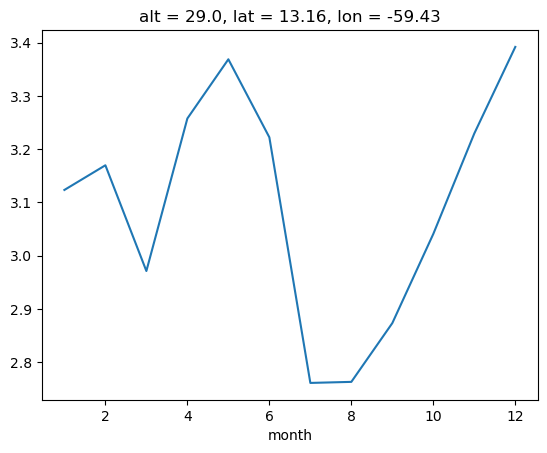

In [25]:
(std_mse/1e3).plot()

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/xarray/groupers.py:530: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.index_grouper = pd.Grouper(


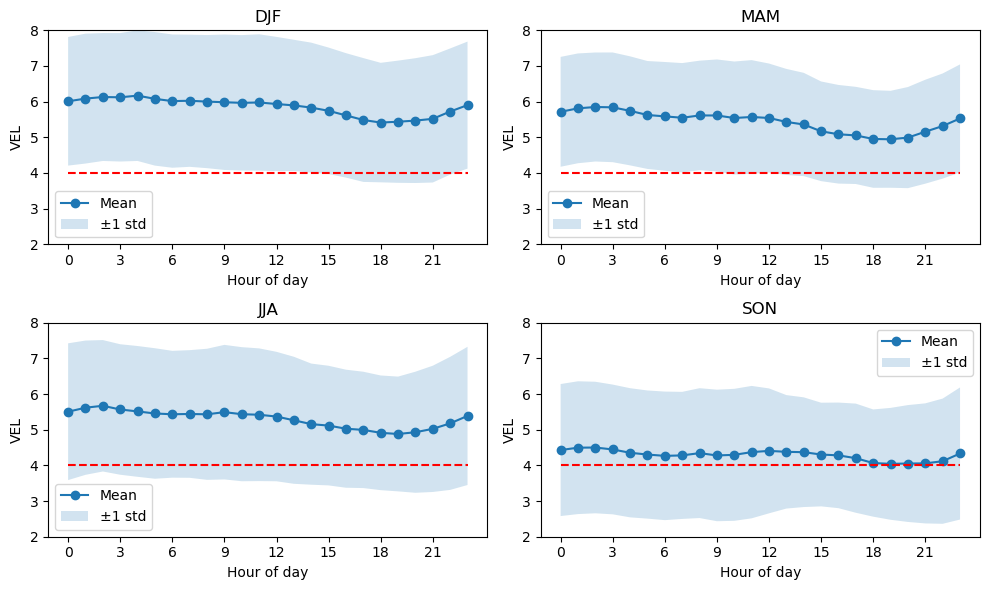

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

vel_hourly = wxt['VEL'].resample(time='1H').mean(skipna=True)

# Add hour-of-day coordinate
vel_hourly = vel_hourly.assign_coords(hour=vel_hourly['time.hour'])

def seasonal_hourly_stats(da):
    """Compute hourly mean and std for each meteorological season."""
    seasons = ['DJF', 'MAM', 'JJA', 'SON']
    means = []
    stds = []
    
    for season in seasons:
        # Select timestamps in this season
        da_season = da.sel(time=da['time.season'] == season)
        # Group by hour and compute mean and std across all years
        mean_hour = da_season.groupby('hour').mean('time', skipna=True)
        std_hour = da_season.groupby('hour').std('time', skipna=True)
        # Assign season coordinate for concatenation
        mean_hour = mean_hour.assign_coords(season=season)
        std_hour = std_hour.assign_coords(season=season)
        means.append(mean_hour)
        stds.append(std_hour)
    
    mean_seasonal = xr.concat(means, dim='season')
    std_seasonal = xr.concat(stds, dim='season')
    
    return mean_seasonal, std_seasonal

mean_hourly, std_hourly = seasonal_hourly_stats(vel_hourly)


fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.flatten()
seasons = ['DJF', 'MAM', 'JJA', 'SON']

for i, season in enumerate(seasons):
    y = mean_hourly.sel(season=season).values
    yerr = std_hourly.sel(season=season).values
    x = np.arange(24)  # hours 0-23
    
    ax[i].plot(x, y, marker='o', label='Mean')
    ax[i].fill_between(x, y - yerr, y + yerr, alpha=0.2, label='±1 std')
    ax[i].set_title(season)
    ax[i].set_xlabel('Hour of day')
    ax[i].set_ylabel('VEL')
    ax[i].set_xticks(np.arange(0, 24, 3))
    ax[i].set_ylim([2,8])
    ax[i].hlines(y=4.0, xmin=x[0], xmax=x[-1], color='red', linestyle='--')
    ax[i].legend()

plt.tight_layout()
plt.show()


### Open from CORAL lidar : 
##### - WV mixing ratio profiles

In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [40]:
coral = cat.BCO.lidar_CORAL_LR_t_c1_v1.to_dask()
coral = coral.sel(time=slice('2020-02-01','2020-02-18'))

lowest_level  = 0.   # m - select all data above this level, as CORAL sees above a certina height only
highest_level = 2500
altitude_mask = (coral.alt>lowest_level) & (coral.alt<highest_level)

coral

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 201MB
Dimensions:    (alt: 484, lim: 2, time: 12960)
Coordinates:
  * alt        (alt) float32 2kB 20.0 80.0 140.0 ... 2.888e+04 2.894e+04 2.9e+04
  * time       (time) datetime64[ns] 104kB 2020-02-01 ... 2020-02-18T23:58:00
Dimensions without coordinates: lim
Data variables:
    alt_bnds   (alt, lim) float32 4kB dask.array<chunksize=(484, 2), meta=np.ndarray>
    dtadz      (time, alt) float32 25MB dask.array<chunksize=(12960, 121), meta=np.ndarray>
    dtadz_err  (time, alt) float32 25MB dask.array<chunksize=(12960, 121), meta=np.ndarray>
    lat        float32 4B ...
    lon        float32 4B ...
    mr         (time, alt) float32 25MB dask.array<chunksize=(12960, 121), meta=np.ndarray>
    mr_err     (time, alt) float32 25MB dask.array<chunksize=(12960, 121), meta=np.ndarray>
    rh         (time, alt) float32 25MB dask.array<chunksize=(12960, 121), meta=np.ndarray>
    rh_err     (time, alt) float32 25MB dask.array<chunksize=(12960, 121), meta=np.ndarray>
    ta         (time, alt) float32 25MB dask.array<chunksize=(12960, 121), meta=np.ndarray>
    ta_err     (time, alt) float32 25MB dask.array<chunksize=(12960, 121), meta=np.ndarray>
Attributes: (12/21)
    Conventions:                  CF-1.7
    altitude_meter_asl:           20.0
    calendar:                     gregorian
    calibration_version:          https://gitlab.gwdg.de/bco/calibration-rama...
    detection_mode:               photoncounting
    evaluation_method:            Raman
    ...                           ...
    start_time:                   2019-01-21T000200+00:00
    stop_time:                    2019-01-22T000000+00:00
    temporal_resolution_seconds:  120.0
    temporal_smoothing_seconds:   3600.0
    title:                        water vapor, temperature, humidity, tempera...
    zenith_angle_degrees:         0.0

In [41]:
# Extract variables
coral_mr, mr_err     = coral['mr'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level)) , coral['mr_err'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level))
coral_ta, ta_err     = coral['ta'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level)) , coral['ta_err'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level))
coral_rh, rh_err     = coral['rh'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level)) , coral['rh_err'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level))

# strange values in e.g. slice("2020-02-19T00:58:00", "2020-02-19T15:58:00")
# --- clean unreasonable values

accept_mask = (coral_mr>0.)&(coral_mr<25e-3)&(mr_err/coral_mr < 5e-2)&(coral_ta>0.)&(coral_ta<350)&(ta_err/coral_ta < 5e-2)

coral_mr = coral_mr.where(accept_mask)
coral_ta = coral_ta.where(accept_mask)
coral_rh = coral_rh.where(accept_mask)


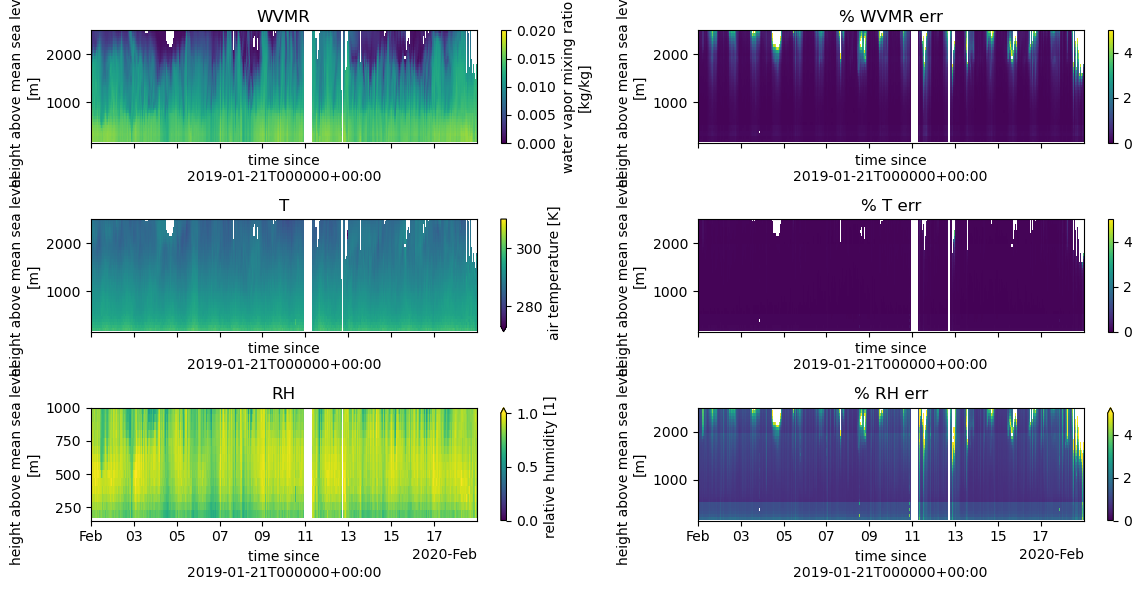

In [8]:
# Create stacked subplots
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 6), sharex=True)
axs = axs.flatten()

# Plot each xarray DataArray on its own subplot
coral_mr.plot(ax=axs[0], vmin=0e-3, vmax=20e-3)  ;                 axs[0].set_title('WVMR')
coral_ta.plot(ax=axs[2], vmin=273, vmax=310)     ;                 axs[2].set_title('T')
coral_rh.plot(ax=axs[4], vmin=0, vmax=1)         ;                 axs[4].set_title('RH')

# Plot each xarray DataArray on its own subplot
(100*mr_err/coral_mr).plot(ax=axs[1] , vmin=0, vmax=5)   ;  axs[1].set_title('% WVMR err')
(100*ta_err/coral_ta).plot(ax=axs[3] , vmin=0, vmax=5)   ;  axs[3].set_title('% T err')
(100*rh_err/coral_rh).plot(ax=axs[5] , vmin=0, vmax=5)   ;  axs[5].set_title('% RH err')

for i, ax in enumerate(axs):
    ax.set_ylim([lowest_level, highest_level])
    if i == 4:
        ax.set_ylim([lowest_level, 1000])

plt.tight_layout()
plt.show()



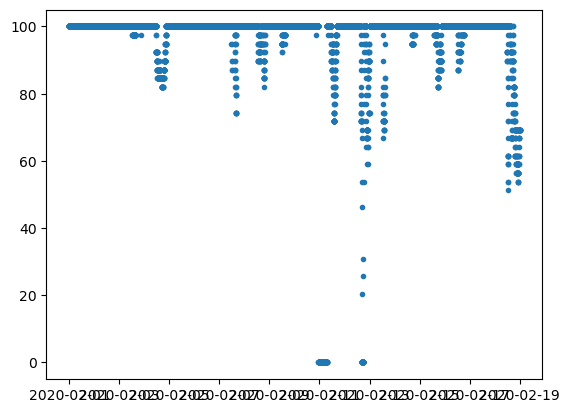

In [6]:
pop_mr = coral_mr[altitude_mask].notnull().sum(dim='alt')/(coral.alt[altitude_mask].size)
plt.plot(coral_mr.time, pop_mr*100, '.')

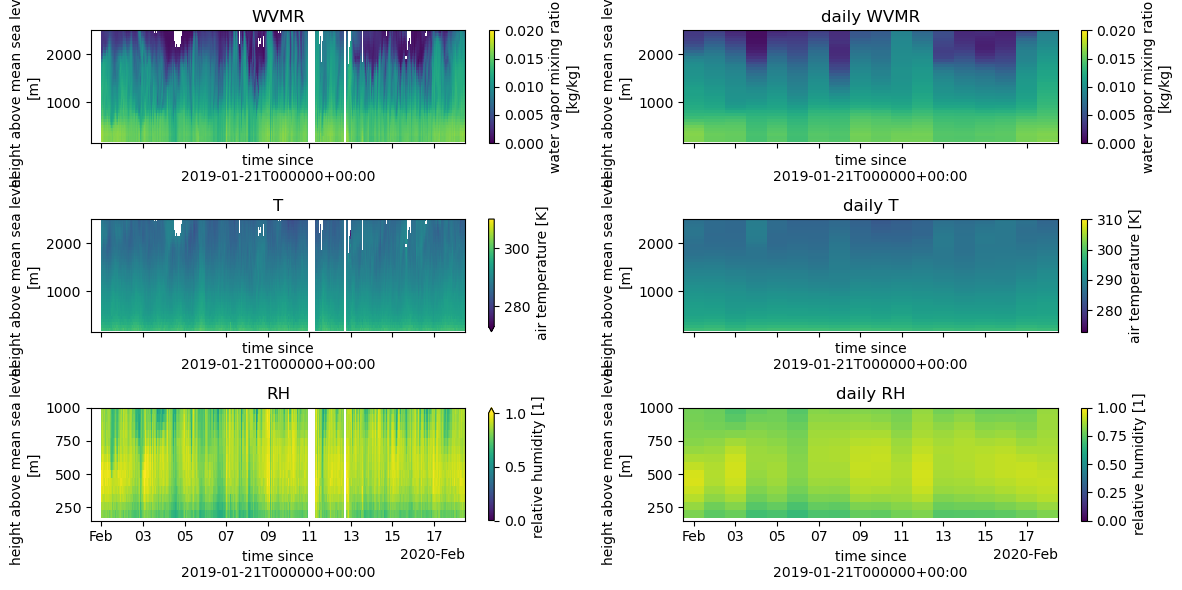

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [ ]:
## --- observe what happens when averaging over time - DAILY MEANS

coral_q_day = coral_mr.resample(time='1d').mean(skipna=True)
coral_T_day = coral_ta.resample(time='1d').mean(skipna=True)
coral_rh_day = coral_rh.resample(time='1d').mean(skipna=True)


fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 6), sharex=True)
axs = axs.flatten()

# --- Plot each xarray DataArray on its own subplot

coral_mr.plot(ax=axs[0], vmin=0e-3, vmax=20e-3)  ;                 axs[0].set_title('WVMR')
coral_ta.plot(ax=axs[2], vmin=273, vmax=310)     ;                 axs[2].set_title('T')
coral_rh.plot(ax=axs[4], vmin=0, vmax=1)         ;                 axs[4].set_title('RH')

coral_q_day.plot(ax=axs[1], vmin=0e-3, vmax=20e-3)  ;                 axs[1].set_title('daily WVMR')
coral_T_day.plot(ax=axs[3], vmin=273, vmax=310)     ;                 axs[3].set_title('daily T')
coral_rh_day.plot(ax=axs[5], vmin=0, vmax=1)        ;                 axs[5].set_title('daily RH')

for i , ax in enumerate(axs):
    ax.set_ylim([lowest_level, highest_level])
    if i == 4 or i == 5 :
        ax.set_ylim([lowest_level, 1000])



plt.tight_layout()
plt.show()


In [42]:
# --- observe some profiles of derived quantities, such as MSE

# --- define specific heats of interest
cp = 1004   # J / Kg K
Lv = 2.5e6  # J / Kg
g  = 9.81   # m/s2  

DSE     = cp*coral_ta  + g*coral_ta.alt
MSE     = DSE + Lv*coral_mr
MSE_sat     = DSE + Lv*(coral_mr/coral_rh)

# DSE_day = DSE.resample(time="1d").mean(skipna=True)
# MSE_day = MSE.resample(time="1d").mean(skipna=True)
# MSE_sat_day = MSE_sat.resample(time="1d").mean(skipna=True)


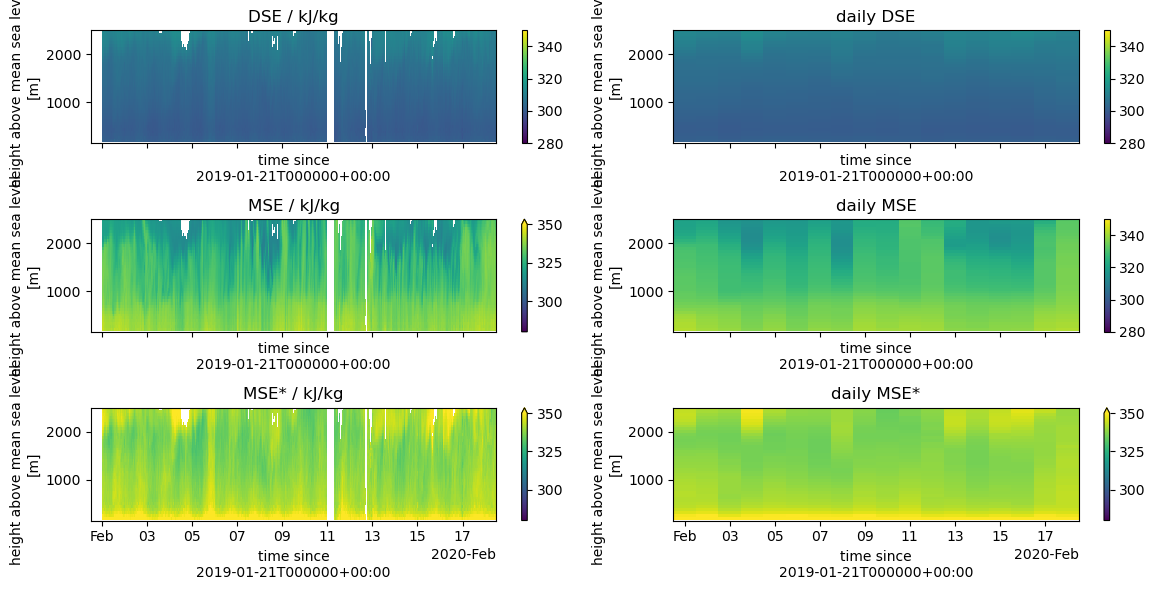

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [9]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 6), sharex=True)
axs = axs.flatten()

# --- Plot each xarray DataArray on its own subplot

(DSE/1e3).plot(ax=axs[0], vmin=280, vmax=350)     ;             axs[0].set_title('DSE / kJ/kg')
(MSE/1e3).plot(ax=axs[2], vmin=280, vmax=350)     ;             axs[2].set_title('MSE / kJ/kg')
(MSE_sat/1e3).plot(ax=axs[4], vmin=280, vmax=350) ;             axs[4].set_title('MSE* / kJ/kg')

(DSE_day/1e3).plot(ax=axs[1], vmin=280, vmax=350)     ;         axs[1].set_title('daily DSE')
(MSE_day/1e3).plot(ax=axs[3], vmin=280, vmax=350)     ;         axs[3].set_title('daily MSE')
(MSE_sat_day/1e3).plot(ax=axs[5], vmin=280, vmax=350) ;         axs[5].set_title('daily MSE*')


for ax in axs:
    ax.set_ylim([lowest_level, highest_level])

plt.tight_layout()
plt.show()


/tmp/ipykernel_4051681/188182614.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('turbo')


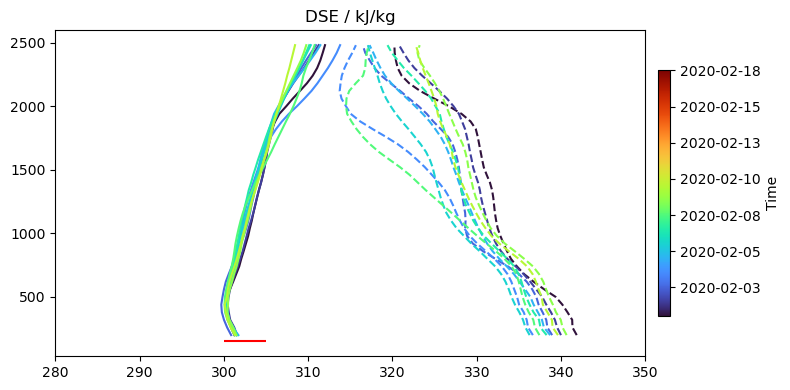

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/num

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Convert all times to Matplotlib date numbers
time_nums = mdates.date2num(DSE_day.time)

# Normalize times to 0–1 for the colormap
norm = mcolors.Normalize(vmin=time_nums.min(), vmax=time_nums.max())
cmap = cm.get_cmap('turbo')




fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 4), sharex=True)

for i in range(0,10,1):
    color = cmap(norm(time_nums[i]))  # get an RGBA color from the time
    axs.plot(DSE_day[:, i] / 1e3, DSE_day.alt, c=color)
    axs.plot(MSE_day[:, i] / 1e3, MSE_day.alt, linestyle='--', c=color)

axs.set_title('DSE / kJ/kg')
axs.hlines(y=lowest_level, xmin=300, xmax=305, color='red')

axs.set_xlim(280, 350)
# axs.set_ylim(lowest_level, highest_level)

# Add a colorbar showing the mapping between color and time
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(sm, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label('Time')
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()


the CORAL profiles start from a height of 200m

### I'm curious what is going on with MSE* over the hourly timescale 
-- it's just temperature looping

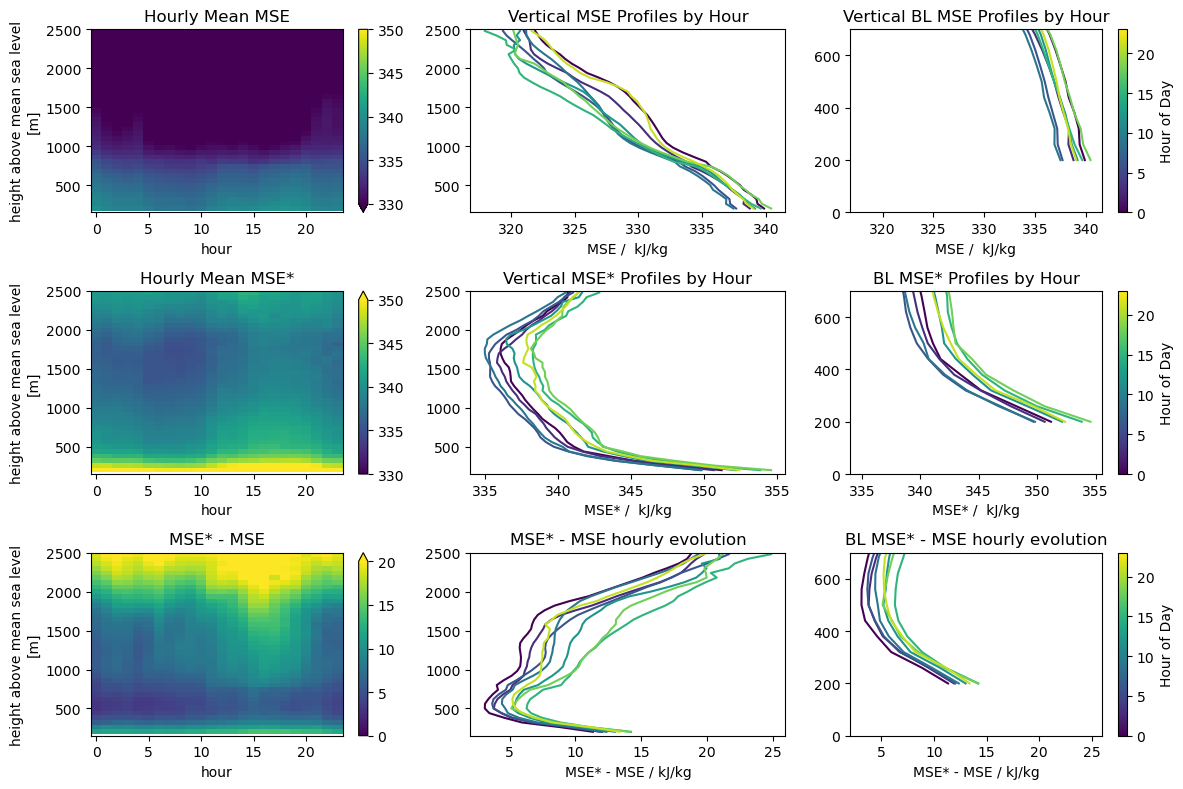

In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# - buid normalized colormap based on hour of day
norm = mcolors.Normalize(vmin=0, vmax=23)
cmap = plt.colormaps["viridis"] #cm.get_cmap("viridis")  # choose any e.g. 'plasma', 'cividis', etc.


fig, ax = plt.subplots(3, 3, figsize=(12, 8))
# ax = ax.flatten()


# - hourly cycle in MSE ?
mse_h = (MSE / 1e3).resample(time="1h").mean(skipna=True).groupby("time.hour").mean(skipna=True)
mse_h.plot(ax=ax[0,0], vmin=330, vmax=350)
ax[0,0].set_title("Hourly Mean MSE")

# - MSE vertical profiles per hour
for i in range(0, 23, 3):
    hour  = mse_h.hour.values[i]
    color = cmap(norm(hour))
    ax[0,1].plot(mse_h[:, i], mse_h.alt, color=color, label=f"{hour:02d}h")

ax[0,1].set_xlabel("MSE /  kJ/kg")
ax[0,1].set_title("Vertical MSE Profiles by Hour")

# focus on BL
for i in range(0, 23, 3):
    hour  = mse_h.hour.values[i]
    color = cmap(norm(hour))
    ax[0,2].plot(mse_h[:, i], mse_h.alt, color=color, label=f"{hour:02d}h")

ax[0,2].set_xlabel("MSE /  kJ/kg")
ax[0,2].set_title("Vertical BL MSE Profiles by Hour")
ax[0,2].set_ylim(0,700)


# - Compute and plot hourly mean MSE*
mse_sat_h = (MSE_sat / 1e3).resample(time="1h").mean(skipna=True).groupby("time.hour").mean(skipna=True)
mse_sat_h.plot(ax=ax[1,0], vmin=330, vmax=350)
ax[1,0].set_title("Hourly Mean MSE*")


# - MSE* vertical profiles per hour
for i in range(0, 23, 3):
    hour  = mse_sat_h.hour.values[i]
    color = cmap(norm(hour))
    ax[1,1].plot(mse_sat_h[:, i], mse_sat_h.alt, color=color, label=f"{hour:02d}h")

ax[1,1].set_xlabel("MSE* /  kJ/kg")
ax[1,1].set_title("Vertical MSE* Profiles by Hour")

# focus on BL
for i in range(0, 23, 3):
    hour  = mse_sat_h.hour.values[i]
    color = cmap(norm(hour))
    ax[1,2].plot(mse_sat_h[:, i], mse_sat_h.alt, color=color, label=f"{hour:02d}h")

ax[1,2].set_ylim(0,700)
ax[1,2].set_xlabel("MSE* /  kJ/kg")
ax[1,2].set_title("BL MSE* Profiles by Hour")



# --- is the hourly cycle in MSE* only explainable with temperature? yes
mse_diff_h    = ( (MSE_sat - MSE) / 1e3).resample(time="1h").mean(skipna=True).groupby("time.hour").mean(skipna=True)
mse_diff_h.plot(ax=ax[2,0], vmin=0, vmax=20)
ax[2,0].set_title("MSE* - MSE")

# - difference
for i in range(0, 23, 3):
    hour  = mse_diff_h.hour.values[i]
    color = cmap(norm(hour))
    ax[2,1].plot(mse_diff_h[:, i], mse_diff_h.alt, color=color, label=f"{hour:02d}h")
ax[2,1].set_xlabel("MSE* - MSE / kJ/kg")
ax[2,1].set_title("MSE* - MSE hourly evolution")

# - focus on BL
for i in range(0, 23, 3):
    hour  = mse_diff_h.hour.values[i]
    color = cmap(norm(hour))
    ax[2,2].plot(mse_diff_h[:, i], mse_diff_h.alt, color=color, label=f"{hour:02d}h")
ax[2,2].set_xlabel("MSE* - MSE / kJ/kg")
ax[2,2].set_title("BL MSE* - MSE hourly evolution")
ax[2,2].set_ylim(0,700)


# - add a colorbar for hours
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])



for i,x in enumerate(ax.flatten()):
    if i%3==0 or i%3 == 1:
        x.set_ylim(lowest_level, highest_level)
    if (i+1)%3 == 0 :
        plt.colorbar(sm, ax=x, label="Hour of Day")

plt.tight_layout()
plt.show()


#### compare Lidar with radiosondes in EUREC4A


In [12]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

In [13]:
## --- I downloaded the Level 2 version of EUREC4A profiles
level2_path = "/work/mh1498/m301248/TCO_data/eurec4a_profiles_level2/EUREC4A_BCO_Vaisala-RS_L2_v3.0.0.nc"

import xarray as xr

ds = xr.open_dataset(level2_path)
# Create boolean index for soundings where month == 2
mask = ds.launch_time.dt.month == 2

# Select along 'sounding' dimension
ds_filtered = ds.sel(sounding=mask)
ds_filtered

<xarray.Dataset> Size: 43MB
Dimensions:      (sounding: 182, alt: 3100, nv: 2)
Coordinates:
  * sounding     (sounding) <U40 29kB 'BCO__descent__12.98_-59.27__2020020100...
  * alt          (alt) int16 6kB 0 10 20 30 40 ... 30950 30960 30970 30980 30990
    flight_time  (sounding, alt) datetime64[ns] 5MB ...
    lat          (sounding, alt) float32 2MB ...
    lon          (sounding, alt) float32 2MB ...
    launch_time  (sounding) datetime64[ns] 1kB 2020-02-01T00:12:17.439354 ......
Dimensions without coordinates: nv
Data variables: (12/19)
    p            (sounding, alt) float32 2MB ...
    dz           (sounding, alt) float32 2MB ...
    ta           (sounding, alt) float32 2MB ...
    dp           (sounding, alt) float32 2MB ...
    wspd         (sounding, alt) float32 2MB ...
    u            (sounding, alt) float32 2MB ...
    ...           ...
    rh           (sounding, alt) float32 2MB ...
    N_ptu        (sounding, alt) float32 2MB ...
    N_gps        (sounding, alt) float32 2MB ...
    m_ptu        (sounding, alt) int16 1MB ...
    m_gps        (sounding, alt) int16 1MB ...
    ascent_flag  (sounding) int16 364B ...
Attributes: (12/13)
    title:            EUREC4A level 2 sounding data
    platform:         BCO
    instrument:       Radiosonde RS41-SGP by Vaisala
    doi:              10.25326/137
    created_with:     batch_interpolate_soundings.py with its last modificati...
    created_on:       Tue Dec 22 18:54:59 2020
    ...               ...
    Conventions:      CF-1.7
    campaign_id:      EUREC4A
    references:       Stephan et al. (2020): Ship- and island-based atmospher...
    acknowledgement:  The MPI-M is listed as the institute of first contact. ...
    instrument_id:    Vaisala-RS
    version:          v3.0.0

Text(0.5, 0, 'MSE / J/g')

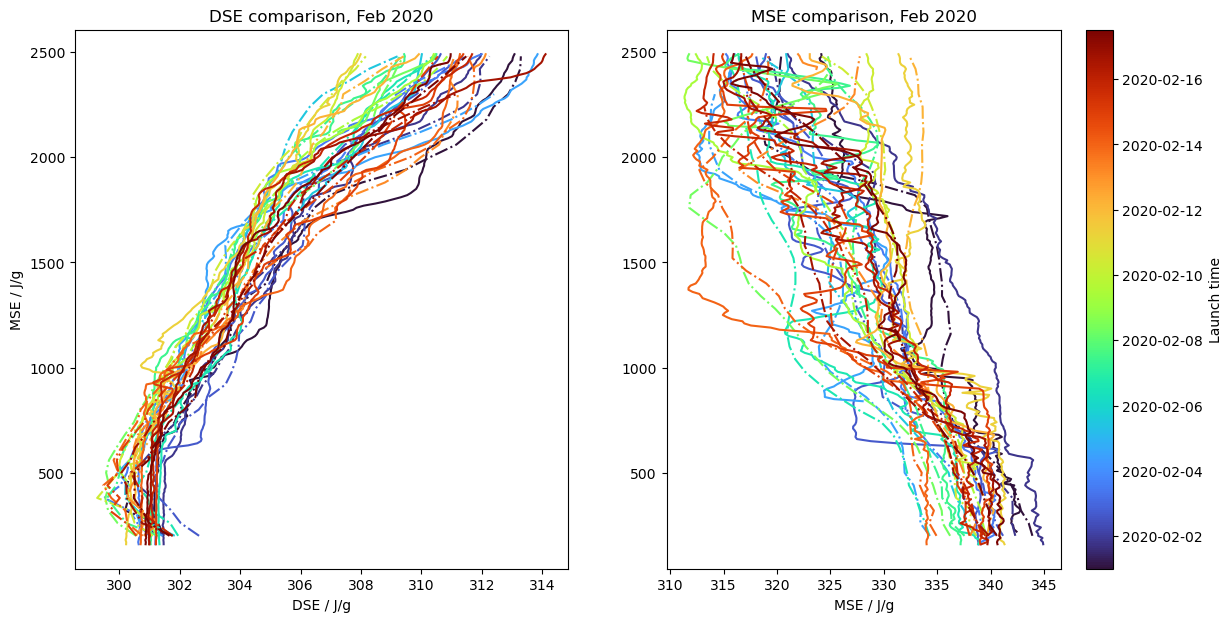

In [ ]:


# Convert launch_time to matplotlib numeric dates
time_nums = mdates.date2num(ds_filtered.launch_time.values)

# Create colormap
norm = mcolors.Normalize(vmin=time_nums.min(), vmax=time_nums.max())
cmap = plt.colormaps['turbo']


fig, ax = plt.subplots(1, 2, figsize=(14, 7))

for i, lt in enumerate(ds_filtered.launch_time[::10]):

    # Find the closest DSE profile in time
    time_sep = pd.to_timedelta(DSE.time - lt)
    closest_idx = np.argmin(np.abs(time_sep))
    closest_DSE_coral_pr = DSE.sel(time=DSE.time[closest_idx])
    closest_MSE_coral_pr = MSE.sel(time=DSE.time[closest_idx])

    # Get the sounding index for radiosonde
    sounding_idx = np.argmin(np.abs(pd.to_timedelta(ds_filtered.launch_time - lt)))

    # Compute color for this launch_time
    color = cmap(norm(mdates.date2num(lt)))

    # --- Plot coral DSE profile ---
    ax[0].plot(closest_DSE_coral_pr / 1e3, closest_DSE_coral_pr.alt, linestyle='-.', color=color)
    ax[1].plot(closest_MSE_coral_pr / 1e3, closest_MSE_coral_pr.alt, linestyle='-.', color=color)

    # --- Plot radiosonde profile ---
    alt_pr = ds_filtered.alt
    alt_mask = (alt_pr < highest_level) & (alt_pr > lowest_level)
    alt_pr = alt_pr[alt_mask]

    dse_pr = cp * (ds_filtered["ta"].isel(sounding=sounding_idx)) + g * ds_filtered.alt
    mse_pr = dse_pr + Lv*ds_filtered["mr"].isel(sounding=sounding_idx)
    
    dse_pr = dse_pr[alt_mask]
    mse_pr = mse_pr[alt_mask]

    ax[0].plot(dse_pr / 1e3, alt_pr, color=color)
    ax[1].plot(mse_pr / 1e3, alt_pr, color=color)


sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[1])
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
cbar.set_label('Launch time')

ax[0].set_title("DSE comparison, Feb 2020")
ax[0].set_xlabel(r"DSE / J/g")
ax[0].set_ylabel(r"MSE / J/g")

ax[1].set_title("MSE comparison, Feb 2020")
ax[1].set_xlabel(r"MSE / J/g")



Text(0.5, 0, 'MSE / J/g')

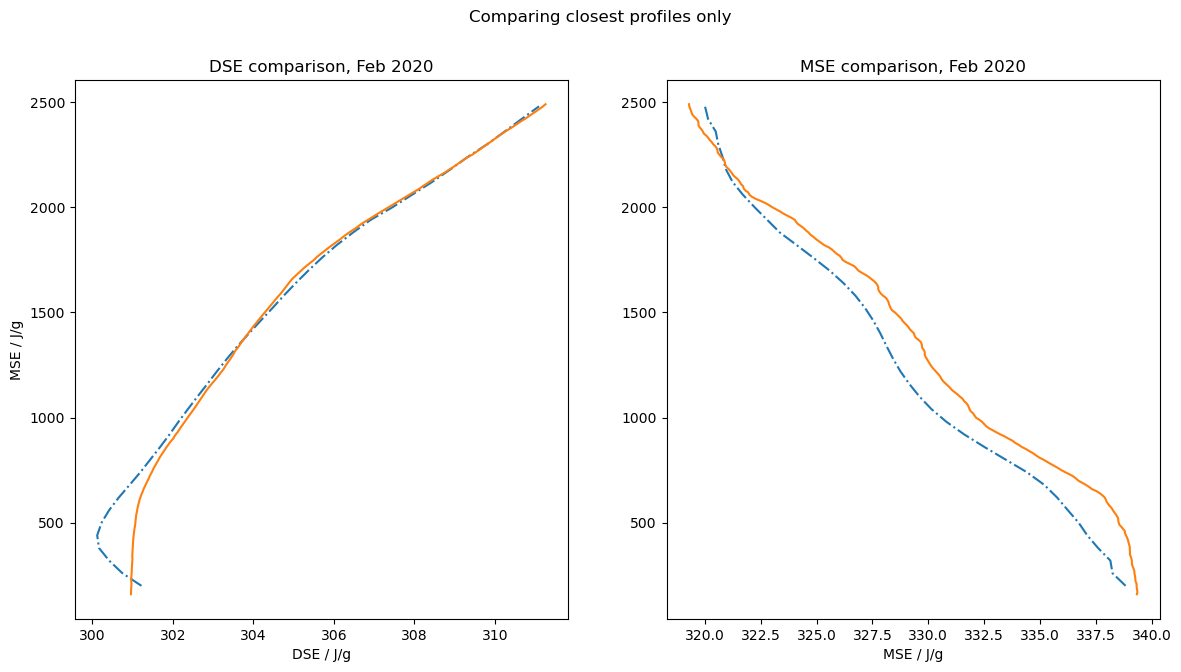

In [50]:

# Convert launch_time to matplotlib numeric dates
time_nums = mdates.date2num(ds_filtered.launch_time.values)



fig, ax = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle("Comparing closest profiles only")


# - collect index of closest profiles all in one list
closest_indices = []
for i, lt in enumerate(ds_filtered.launch_time):

    # Find the closest DSE profile in time
    time_sep = pd.to_timedelta(DSE.time - lt)
    closest_idx = np.argmin(np.abs(time_sep))
    closest_indices.append(closest_idx)


closest_DSE_coral_mean = DSE.sel(time=DSE.time[closest_indices]).mean(dim="time", skipna=True)
closest_MSE_coral_mean = MSE.sel(time=DSE.time[closest_indices]).mean(dim="time", skipna=True)


# --- Plot coral DSE profile ---
ax[0].plot(closest_DSE_coral_mean / 1e3, closest_DSE_coral_mean.alt, linestyle='-.')
ax[1].plot(closest_MSE_coral_mean / 1e3, closest_MSE_coral_mean.alt, linestyle='-.')

# --- Plot radiosonde profile ---
alt_pr = ds_filtered.alt
alt_mask = (alt_pr < highest_level) & (alt_pr > lowest_level)
alt_pr = alt_pr[alt_mask]

dse_pr = (cp * (ds_filtered["ta"]) + g * ds_filtered.alt).mean(dim="sounding", skipna=True)
mse_pr = (cp * (ds_filtered["ta"]) + g * ds_filtered.alt + Lv*ds_filtered["mr"]).mean(dim="sounding", skipna=True)

dse_pr = dse_pr[alt_mask]
mse_pr = mse_pr[alt_mask]

ax[0].plot(dse_pr / 1e3, alt_pr)
ax[1].plot(mse_pr / 1e3, alt_pr)


ax[0].set_title("DSE comparison, Feb 2020")
ax[0].set_xlabel(r"DSE / J/g")
ax[0].set_ylabel(r"MSE / J/g")

ax[1].set_title("MSE comparison, Feb 2020")
ax[1].set_xlabel(r"MSE / J/g")



In [18]:
# --- build profiles of saturated MSE

MSE_pr_sat  = cp*(ds_filtered["ta"]) + g * ds_filtered.alt + Lv*(ds_filtered["mr"]/ds_filtered["rh"])

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: Run

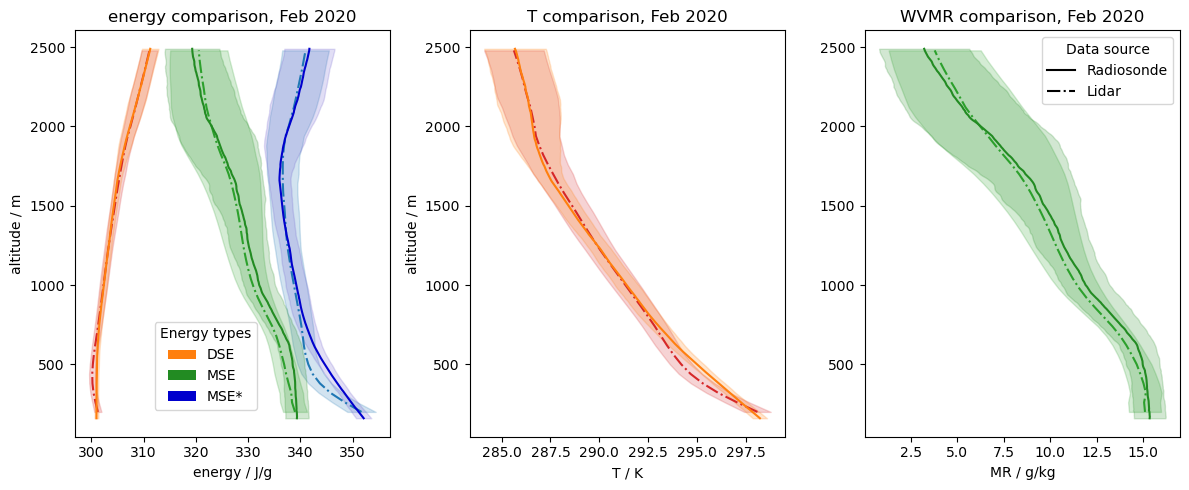

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
# ax = ax.flatten()

# --- Plot coral DSE profile ---
DSE_mean = DSE.mean(dim='time', skipna=True)
MSE_mean = MSE.mean(dim='time', skipna=True)
MSE_sat_mean = MSE_sat.mean(dim='time', skipna=True)

ax[0].plot( DSE_mean/ 1e3, DSE.alt, linestyle='-.', color="tab:red")
ax[0].plot( MSE_mean / 1e3, MSE.alt, linestyle='-.', color="tab:green")
ax[0].plot( MSE_sat_mean / 1e3, MSE.alt, linestyle='-.', color="tab:blue")


DSE_std  = DSE.std(dim='time', skipna=True)
MSE_std  = MSE.std(dim='time', skipna=True)
MSE_sat_std = MSE_sat.std(dim='time', skipna=True)


ax[0].fill_betweenx(
    DSE.alt,
    (DSE_mean - DSE_std) / 1e3,
    (DSE_mean + DSE_std) / 1e3,
    color="tab:red",
    alpha=0.2,
    label='±1 std (time)'
)

ax[0].fill_betweenx(
    MSE.alt,
    (MSE_mean - MSE_std) / 1e3,
    (MSE_mean + MSE_std) / 1e3,
    color="tab:green",
    alpha=0.2,
    label='±1 std (time)'
)

ax[0].fill_betweenx(
    MSE_sat.alt,
    (MSE_sat_mean - MSE_sat_std) / 1e3,
    (MSE_sat_mean + MSE_sat_std) / 1e3,
    color="tab:blue",
    alpha=0.2,
    label='±1 std (time)'
)




# --- Plot radiosonde profile ---
# alt_pr = ds_filtered.alt
# alt_mask = (alt_pr < highest_level) & (alt_pr > lowest_level)
# alt_pr = alt_pr[alt_mask]

# dse_pr_mean = cp * (ds_filtered["ta"].mean(dim="sounding", skipna=True)) + g * ds_filtered.alt
# mse_pr_mean = dse_pr_mean + Lv*ds_filtered["mr"].mean(dim="sounding", skipna=True)
# mse_pr_sat_mean = MSE_pr_sat.mean(dim="sounding", skipna=True)

# dse_pr_std = cp * (ds_filtered["ta"].std(dim="sounding", skipna=True))
# mse_pr_std = (cp*ds_filtered["ta"]+Lv*ds_filtered["mr"]).std(dim="sounding", skipna=True)
# mse_pr_sat_std = MSE_pr_sat.std(dim="sounding", skipna=True)

# dse_pr_mean = dse_pr_mean[alt_mask]
# mse_pr_mean = mse_pr_mean[alt_mask]
# mse_pr_sat_mean = mse_pr_sat_mean[alt_mask]

# ax[0].plot(dse_pr_mean / 1e3, alt_pr, color="tab:orange")
# ax[0].plot(mse_pr_mean / 1e3, alt_pr, color="forestgreen")
# ax[0].plot(mse_pr_sat_mean / 1e3, alt_pr, color="mediumblue")


# ax[0].fill_betweenx(
#     alt_pr,
#     (dse_pr_mean - dse_pr_std) / 1e3,
#     (dse_pr_mean + dse_pr_std) / 1e3,
#     color="tab:orange",
#     alpha=0.2
# )

# ax[0].fill_betweenx(
#     alt_pr,
#     (mse_pr_mean - mse_pr_std) / 1e3,
#     (mse_pr_mean + mse_pr_std) / 1e3,
#     color="forestgreen",
#     alpha=0.2
# )

# ax[0].fill_betweenx(
#     alt_pr,
#     (mse_pr_sat_mean - mse_pr_sat_std) / 1e3,
#     (mse_pr_sat_mean + mse_pr_sat_std) / 1e3,
#     color="slateblue",
#     alpha=0.2
# )


# ax[0].set_title("energy comparison, Feb 2020")
# ax[0].set_xlabel(r"energy / J/g")
# ax[0].set_ylabel(r"altitude / m")


# - build color legend
from matplotlib.patches import Patch

# Define your legend colors and labels
legend_info = {
    "tab:orange": ("DSE"),
    "forestgreen": ("MSE"),
    "mediumblue": ("MSE*")
}

# Build custom legend handles
legend_elements = [
    Patch(facecolor=color, label=f"{label}")
    for color, (label) in legend_info.items()
]

ax[0].legend(handles=legend_elements, title="Energy types", loc="best", bbox_to_anchor=(0.3, 0., 0.3, 0.3))





# --- plot CORAL temperature and moisture profiles alone here
q_mean = coral_mr.mean(dim='time', skipna=True)
T_mean = coral_ta.mean(dim='time', skipna=True)

ax[2].plot( q_mean*1e3 , q_mean.alt, linestyle='-.', color="tab:green")
ax[1].plot( T_mean , T_mean.alt, linestyle='-.', color="tab:red")

q_std  = coral_mr.std(dim='time', skipna=True)
T_std  = coral_ta.std(dim='time', skipna=True)


ax[2].fill_betweenx(
    coral_mr.alt,
    (q_mean - q_std)*1e3,
    (q_mean + q_std)*1e3,
    color="tab:green",
    alpha=0.2,
    label='±1 std (time)'
)

ax[1].fill_betweenx(
    coral_ta.alt,
    (T_mean - T_std),
    (T_mean + T_std),
    color="tab:red",
    alpha=0.2,
    label='±1 std (time)'
)


# --- Plot temperature and moisture from radiosonde profile ---
alt_pr = ds_filtered.alt
alt_mask = (alt_pr < highest_level) & (alt_pr > lowest_level)
alt_pr = alt_pr[alt_mask]

T_pr_mean = ds_filtered["ta"].mean(dim="sounding", skipna=True)
q_pr_mean = ds_filtered["mr"].mean(dim="sounding", skipna=True)

T_pr_std = ds_filtered["ta"].std(dim="sounding", skipna=True)
q_pr_std = ds_filtered["mr"].std(dim="sounding", skipna=True)

T_pr_mean = T_pr_mean[alt_mask]
q_pr_mean = q_pr_mean[alt_mask]

ax[2].plot(q_pr_mean*1e3 , alt_pr, color="forestgreen")
ax[1].plot(T_pr_mean , alt_pr, color="tab:orange")


ax[2].fill_betweenx(
    alt_pr,
    (q_pr_mean - q_pr_std)*1e3,
    (q_pr_mean + q_pr_std)*1e3,
    color="forestgreen",
    alpha=0.2
)

ax[1].fill_betweenx(
    alt_pr,
    (T_pr_mean - T_pr_std),
    (T_pr_mean + T_pr_std),
    color="tab:orange",
    alpha=0.2
)


ax[2].set_title("WVMR comparison, Feb 2020")
ax[2].set_xlabel(r"MR / g/kg")

ax[1].set_title("T comparison, Feb 2020")
ax[1].set_xlabel(r"T / K")
ax[1].set_ylabel(r"altitude / m")


# - build Lidar vs profile legends
custom_lines = [
    Line2D([0], [0], color='k', linestyle='-', label='Radiosonde'),   # solid line
    Line2D([0], [0], color='k', linestyle='-.', label='Lidar')        # dash-dot line
]

# Add the legend only to ax[2]
ax[2].legend(handles=custom_lines, loc='best', title='Data source')


plt.tight_layout()
plt.show()

In [46]:
# - compare actual profiles with those corrected by Ilya

import glob
import xarray as xr

files = glob.glob("CORAL_eurec4a_postprocessed/*.nc")
files = sorted(files)

corrected_coral = xr.open_mfdataset(files, combine='by_coords').sel(time=slice("2020-02-01", "2020-02-18"))
corrected_coral

/tmp/ipykernel_2182633/2647075267.py:9: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  corrected_coral = xr.open_mfdataset(files, combine='by_coords').sel(time=slice("2020-02-01", "2020-02-18"))


<xarray.Dataset> Size: 251MB
Dimensions:    (time: 12960, alt: 484, lim: 2)
Coordinates:
  * time       (time) datetime64[ns] 104kB 2020-02-01 ... 2020-02-18T23:58:00
  * alt        (alt) float32 2kB 20.0 80.0 140.0 ... 2.888e+04 2.894e+04 2.9e+04
Dimensions without coordinates: lim
Data variables:
    lon        (time) float32 52kB -59.43 -59.43 -59.43 ... -59.43 -59.43 -59.43
    lat        (time) float32 52kB 13.16 13.16 13.16 13.16 ... 13.16 13.16 13.16
    alt_bnds   (time, alt, lim) float32 50MB dask.array<chunksize=(1, 484, 2), meta=np.ndarray>
    ta         (time, alt) float32 25MB dask.array<chunksize=(1, 484), meta=np.ndarray>
    ta_err     (time, alt) float32 25MB dask.array<chunksize=(1, 484), meta=np.ndarray>
    dtadz      (time, alt) float32 25MB dask.array<chunksize=(1, 484), meta=np.ndarray>
    dtadz_err  (time, alt) float32 25MB dask.array<chunksize=(1, 484), meta=np.ndarray>
    mr         (time, alt) float32 25MB dask.array<chunksize=(1, 484), meta=np.ndarray>
    mr_err     (time, alt) float32 25MB dask.array<chunksize=(1, 484), meta=np.ndarray>
    rh         (time, alt) float32 25MB dask.array<chunksize=(1, 484), meta=np.ndarray>
    rh_err     (time, alt) float32 25MB dask.array<chunksize=(1, 484), meta=np.ndarray>
Attributes: (12/21)
    title:                        water vapor, temperature, humidity, tempera...
    campaign:                     EUREC4A
    platform:                     BCO
    instrument:                   CORAL-LIDAR
    institution:                  Max Planck Institute for Meteorology, Hamburg
    altitude_meter_asl:           20.0
    ...                           ...
    temporal_resolution_seconds:  120.0
    temporal_smoothing_seconds:   3600.0
    license:                      to be defined
    history:                      created by Ilya Serikov (ilya.serikov@mpime...
    version:                      1.0.0
    Conventions:                  CF-1.7

In [47]:
# Extract variables
corr_mr, corr_mr_err     = corrected_coral['mr'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level)) , corrected_coral['mr_err'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level))
corr_ta, corr_ta_err     = corrected_coral['ta'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level)) , corrected_coral['ta_err'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level))
corr_rh, corr_rh_err     = corrected_coral['rh'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level)) , corrected_coral['rh_err'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level))

# strange values in e.g. slice("2020-02-19T00:58:00", "2020-02-19T15:58:00")
# --- clean unreasonable values

accept_mask = (corr_mr>0.)&(corr_mr<25e-3)&(corr_mr_err/corr_mr < 5e-2)&(corr_ta>0.)&(corr_ta<350)&(corr_ta_err/corr_ta < 5e-2)

corr_mr = corr_mr.where(accept_mask)
corr_ta = corr_ta.where(accept_mask)
corr_rh = corr_rh.where(accept_mask)

cp = 1004   # J / Kg K
Lv = 2.5e6  # J / Kg
g  = 9.81   # m/s2  

corr_DSE      = cp*corr_ta  + g*corr_ta.alt
corr_MSE      = corr_DSE + Lv*corr_mr
corr_MSE_sat  = corr_DSE + Lv*(corr_mr/corr_rh)




In [48]:
# compute data here
DSE_mean = DSE.mean(dim="time", skipna=True)
DSE_std  = DSE.std(dim='time', skipna=True)

corr_DSE_mean = corr_DSE.mean(dim="time", skipna=True)
corr_DSE_std  = corr_DSE.std(dim='time', skipna=True)

ds_lowProf = ds_filtered.sel(alt=slice(0, highest_level))
dse_pr_mean = cp * (ds_lowProf["ta"].mean(dim="sounding", skipna=True)) + g * ds_lowProf.alt
dse_pr_std = cp * (ds_lowProf["ta"].std(dim="sounding", skipna=True))



# --- MSE quantities

MSE_mean = MSE.mean(dim="time", skipna=True)
MSE_std  = MSE.std(dim='time', skipna=True)

corr_MSE_mean = corr_MSE.mean(dim="time", skipna=True)
corr_MSE_std  = corr_MSE.std(dim='time', skipna=True)

ds_lowProf = ds_filtered.sel(alt=slice(0, highest_level))
mse_pr_mean = cp * (ds_lowProf["ta"].mean(dim="sounding", skipna=True)) + g * ds_lowProf.alt + Lv * (ds_lowProf["mr"].mean(dim="sounding", skipna=True))
mse_pr_std = cp * (ds_lowProf["ta"].std(dim="sounding", skipna=True)) + Lv * (ds_lowProf["mr"].std(dim="sounding", skipna=True))

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [49]:
time_sel_wxt = slice("2020-02-01", "2020-02-18")

wxt_dse = cp*temp.sel(time=time_sel_wxt)
wxt_dse_mean = wxt_dse.sel(time=wxt_dse.time.dt.minute == 30).mean(dim="time")
wxt_dse_std = wxt_dse.sel(time=wxt_dse.time.dt.minute == 30).std(dim="time")


wxt_mse = (cp*temp + Lv*q).sel(time=time_sel_wxt)
wxt_mse_mean = wxt_mse.sel(time=wxt_mse.time.dt.minute == 30).mean(dim="time")
wxt_mse_std = wxt_mse.sel(time=wxt_mse.time.dt.minute == 30).std(dim="time")

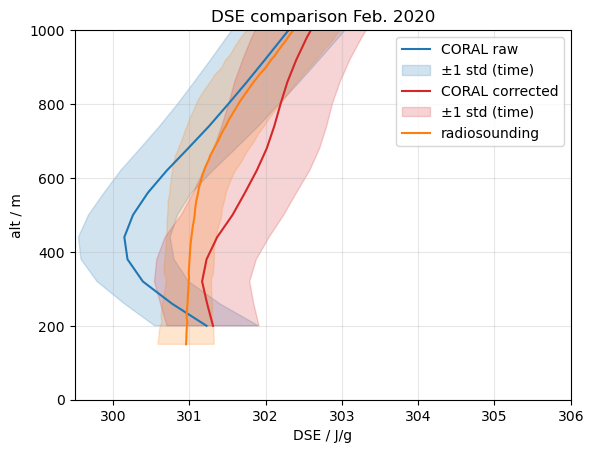

In [ ]:


# - wrx surface DSE and MSE values
plt.plot()


plt.plot(DSE_mean/1e3, DSE.alt, color="tab:blue", label="CORAL raw")
plt.fill_betweenx(
    DSE.alt,
    (DSE_mean - DSE_std) / 1e3,
    (DSE_mean + DSE_std) / 1e3,
    color="tab:blue",
    alpha=0.2,
    label='±1 std (time)'
)


plt.plot(corr_DSE_mean/1e3, corr_DSE.alt, color="tab:red", label="CORAL corrected")
plt.fill_betweenx(
    corr_DSE.alt,
    (corr_DSE_mean - corr_DSE_std) / 1e3,
    (corr_DSE_mean + corr_DSE_std) / 1e3,
    color="tab:red",
    alpha=0.2,
    label='±1 std (time)'
)



# radiosonde profile
plt.plot(dse_pr_mean / 1e3, dse_pr_mean.alt, color="tab:orange", label="radiosounding")
plt.fill_betweenx(
    dse_pr_mean.alt,
    (dse_pr_mean - dse_pr_std) / 1e3,
    (dse_pr_mean + dse_pr_std) / 1e3,
    color="tab:orange",
    alpha=0.2
)

plt.ylim(0,1000)
plt.xlim(299.5, 306)
plt.xlabel("DSE / J/g")
plt.ylabel("alt / m")
plt.title("DSE comparison Feb. 2020")
plt.grid(alpha=0.3)
plt.legend()

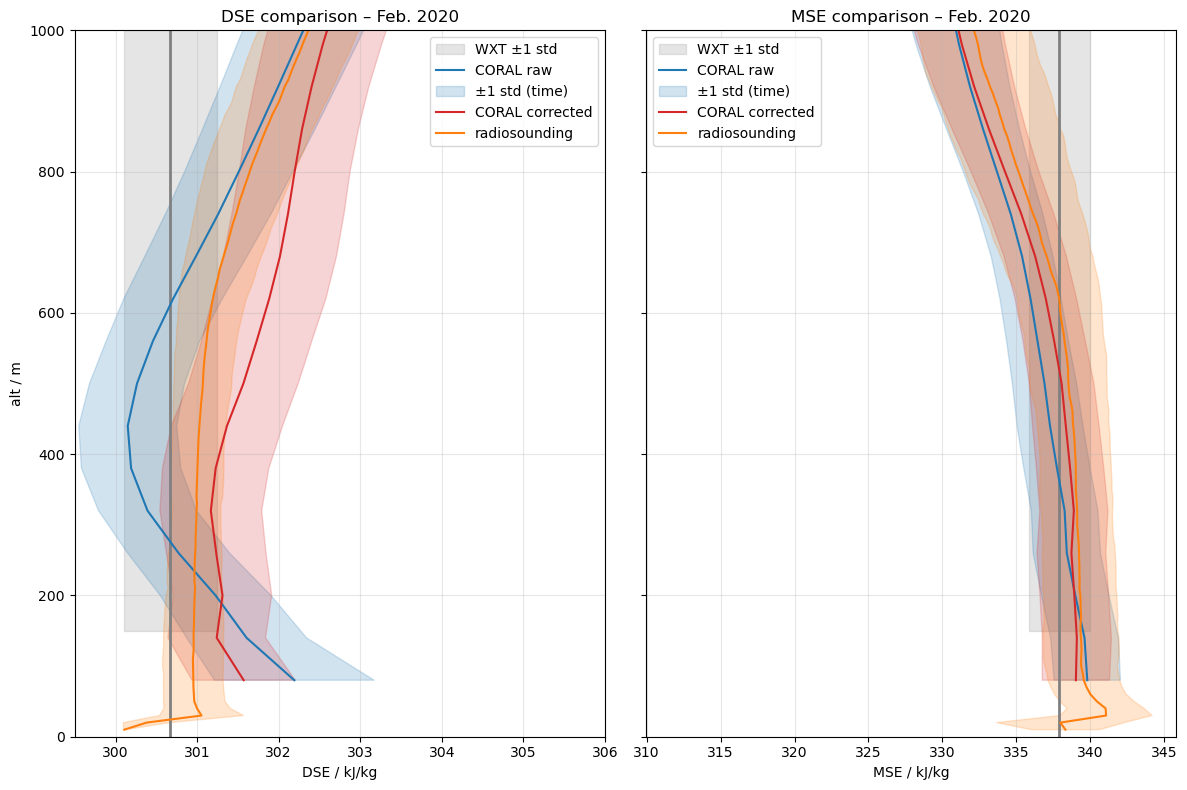

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

# =============================================================
# ==========================  DSE  =============================
# =============================================================

# WXT vertical band: mean ± std between 150–1000 m
ax[0].axvspan(
    (wxt_dse_mean - wxt_dse_std) / 1e3,
    (wxt_dse_mean + wxt_dse_std) / 1e3,
    ymin=150/1000, ymax=1000/1000,
    color="gray", alpha=0.2, label="WXT ±1 std"
)

# Mean line for WXT (vertical)
ax[0].vlines(wxt_dse_mean / 1e3, ymin=0, ymax=1000, color="gray", linewidth=2)

# CORAL raw
ax[0].plot(DSE_mean / 1e3, DSE.alt, color="tab:blue", label="CORAL raw")
ax[0].fill_betweenx(
    DSE.alt,
    (DSE_mean - DSE_std) / 1e3,
    (DSE_mean + DSE_std) / 1e3,
    color="tab:blue", alpha=0.2, label="±1 std (time)"
)

# - CORAL corrected
ax[0].plot(corr_DSE_mean / 1e3, corr_DSE.alt, color="tab:red", label="CORAL corrected")
ax[0].fill_betweenx(
    corr_DSE.alt,
    (corr_DSE_mean - corr_DSE_std) / 1e3,
    (corr_DSE_mean + corr_DSE_std) / 1e3,
    color="tab:red", alpha=0.2
)

# Radiosonde
ax[0].plot(dse_pr_mean / 1e3, dse_pr_mean.alt, color="tab:orange", label="radiosounding")
ax[0].fill_betweenx(
    dse_pr_mean.alt,
    (dse_pr_mean - dse_pr_std) / 1e3,
    (dse_pr_mean + dse_pr_std) / 1e3,
    color="tab:orange", alpha=0.2
)

# Formatting
ax[0].set_ylim(0, 1000)
ax[0].set_xlim(299.5, 306)
ax[0].set_xlabel("DSE / kJ/kg")
ax[0].set_ylabel("alt / m")
ax[0].set_title("DSE comparison – Feb. 2020")
ax[0].grid(alpha=0.3)
ax[0].legend()


# =============================================================
# ==========================  MSE  =============================
# =============================================================

# WXT vertical band: mean ± std between 150–1000 m
ax[1].axvspan(
    (wxt_mse_mean - wxt_mse_std) / 1e3,
    (wxt_mse_mean + wxt_mse_std) / 1e3,
    ymin=150/1000, ymax=1000/1000,
    color="gray", alpha=0.2, label="WXT ±1 std"
)

# Mean line for WXT
ax[1].vlines(wxt_mse_mean / 1e3, ymin=0, ymax=1000, color="gray", linewidth=2)

# CORAL raw
ax[1].plot(MSE_mean / 1e3, MSE.alt, color="tab:blue", label="CORAL raw")
ax[1].fill_betweenx(
    MSE.alt,
    (MSE_mean - MSE_std) / 1e3,
    (MSE_mean + MSE_std) / 1e3,
    color="tab:blue", alpha=0.2, label="±1 std (time)"
)

# CORAL corrected
ax[1].plot(corr_MSE_mean / 1e3, corr_MSE.alt, color="tab:red", label="CORAL corrected")
ax[1].fill_betweenx(
    corr_MSE.alt,
    (corr_MSE_mean - corr_MSE_std) / 1e3,
    (corr_MSE_mean + corr_MSE_std) / 1e3,
    color="tab:red", alpha=0.2
)

# Radiosonde
ax[1].plot(mse_pr_mean / 1e3, mse_pr_mean.alt, color="tab:orange", label="radiosounding")
ax[1].fill_betweenx(
    mse_pr_mean.alt,
    (mse_pr_mean - mse_pr_std) / 1e3,
    (mse_pr_mean + mse_pr_std) / 1e3,
    color="tab:orange", alpha=0.2
)

# Formatting
ax[1].set_ylim(0, 1000)
# ax[1].set_xlim(299.5, 306)
ax[1].set_xlabel("MSE / kJ/kg")
ax[1].set_title("MSE comparison – Feb. 2020")
ax[1].grid(alpha=0.3)
ax[1].legend()

plt.tight_layout()
plt.show()


In [23]:
((wxt_mse_mean - wxt_mse_std) / 1e3).values

array(335.86496, dtype=float32)

## open WindCube data
### $\rightarrow$ Lutz and I have concluded that data is corrupted

In [1]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

import xarray as xr

import glob

In [4]:
ds = xr.open_dataset("/work/mh1498/m301248/hor_wind_BCO/WindCube_202410_unzipped/wind_and_aerosols_data/0-00/WLS200s-180_2024-10-19_00-09-47_dbs_1397_25m.nc")
ds

<xarray.Dataset> Size: 144B
Dimensions:            (sweep: 1)
Coordinates:
  * sweep              (sweep) int32 4B 1
Data variables:
    instrument_type    <U5 20B ...
    lidar_model        <U4 16B ...
    latitude           float64 8B ...
    longitude          float64 8B ...
    altitude           float64 8B ...
    default_latitude   float64 8B ...
    default_longitude  float64 8B ...
    default_altitude   float64 8B ...
    sweep_group_name   (sweep) <U12 48B ...
    sweep_fixed_angle  (sweep) float64 8B ...
Attributes:
    title:            Leosphere Windcube data
    Conventions:      CF/Radial 2.0 , CF-1.7
    institution:      Leosphere
    references:       
    source:           Lidar measurements
    history:          Windcube Lidar server 3.3.4
    comment:          
    instrument_name:  WLS200s-180

In [7]:
files_dbs = sorted(glob.glob("/work/mh1498/m301248/hor_wind_BCO/WindCube_202410_unzipped/wind_and_aerosols_data/0-00/*dbs*.nc"))

# Open and concatenate
ds = xr.open_mfdataset(
    files_dbs,
    combine="nested",
    concat_dim="sweep",     # ← or any dimension you expect
)
ds

/tmp/ipykernel_405735/617760703.py:4: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  ds = xr.open_mfdataset(


<xarray.Dataset> Size: 4kB
Dimensions:            (sweep: 30)
Coordinates:
  * sweep              (sweep) int32 120B 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Data variables:
    instrument_type    (sweep) <U5 600B 'lidar' 'lidar' ... 'lidar' 'lidar'
    lidar_model        (sweep) <U4 480B '200s' '200s' '200s' ... '200s' '200s'
    latitude           (sweep) float64 240B 13.16 13.16 13.16 ... 13.16 13.16
    longitude          (sweep) float64 240B -59.43 -59.43 ... -59.43 -59.43
    altitude           (sweep) float64 240B nan nan nan nan ... nan nan nan nan
    default_latitude   (sweep) float64 240B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    default_longitude  (sweep) float64 240B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    default_altitude   (sweep) float64 240B nan nan nan nan ... nan nan nan nan
    sweep_group_name   (sweep) <U12 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    sweep_fixed_angle  (sweep) float64 240B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    title:            Leosphere Windcube data
    Conventions:      CF/Radial 2.0 , CF-1.7
    institution:      Leosphere
    references:       
    source:           Lidar measurements
    history:          Windcube Lidar server 3.3.4
    comment:          
    instrument_name:  WLS200s-180

### open Doppler wind profiler

In [3]:
windlidar = cat.BCO.windlidar2_c1_v1.to_dask()
windlidar

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 82GB
Dimensions:       (time: 33463547, alt: 100)
Coordinates:
  * time          (time) datetime64[ns] 268MB 2019-02-18T14:21:24.069600 ... ...
  * alt           (alt) float64 800B 36.0 66.0 96.0 ... 2.976e+03 3.006e+03
    lat           float64 8B ...
    lon           float64 8B ...
Data variables:
    azi           (time) float64 268MB dask.array<chunksize=(262144,), meta=np.ndarray>
    beta          (time, alt) float64 27GB dask.array<chunksize=(8192, 32), meta=np.ndarray>
    doppler       (time, alt) float64 27GB dask.array<chunksize=(8192, 32), meta=np.ndarray>
    focus         (time) int64 268MB dask.array<chunksize=(262144,), meta=np.ndarray>
    gate_length   float64 8B ...
    gates_number  int64 8B ...
    intensity     (time, alt) float64 27GB dask.array<chunksize=(8192, 32), meta=np.ndarray>
    pitch         (time) float64 268MB dask.array<chunksize=(262144,), meta=np.ndarray>
    pulses        (time) int64 268MB dask.array<chunksize=(262144,), meta=np.ndarray>
    resolution    float64 8B ...
    roll          (time) float64 268MB dask.array<chunksize=(262144,), meta=np.ndarray>
    zenith        (time) float64 268MB dask.array<chunksize=(262144,), meta=np.ndarray>
Attributes:
    Conventions:      CF-1.12
    bcoproc_version:  0.0.0.post540.dev0+8fd9c92
    history:          processed with bcoproc l1
    institution:      Max Planck Institute for Meteorology, Hamburg
    license:          CC0-1.0
    location:         The Barbados Cloud Observatory, Deebles Point, Barbados...
    platform:         BCO
    source:           Halo Photonics Stream Line Pro Scanning Doppler Lidar
    summary:          The Halo Photonics Stream Line Pro Scanning Doppler Lid...
    title:            WindLidar data from BCO (Level 1)
    tool_versions:    {"Python": "3.11.2 (main, Apr 28 2025, 14:11:48) [GCC 1...

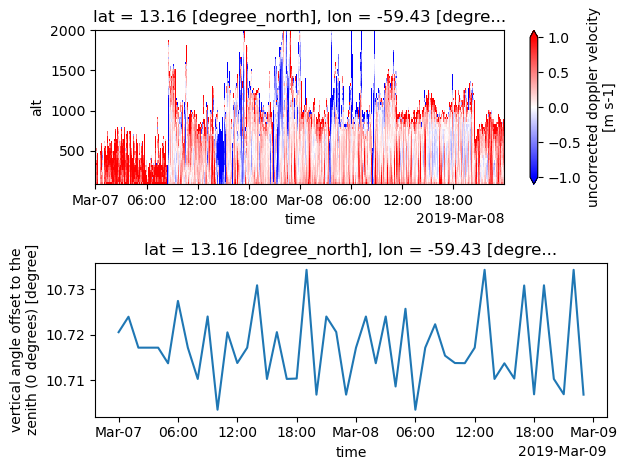

In [4]:
def is_vertical(ds):
    return ds["zenith"] < 2

def is_reliable(ds):
    # mask signals from the point where it became too much attenuated
    return (ds["intensity"] <= 1.015).cumsum("alt") < 1

# cut, filter, resample and plot the data
wl1_day = windlidar.sel(time=slice("2019-03-07", "2019-03-08"), alt=slice(70, 2000))
wl1_1min_avg = wl1_day["doppler"].where(is_reliable(wl1_day)).resample(time="1min").mean()



fig, ax = plt.subplots(2,1)
ax=ax.flatten()

wl1_1min_avg.plot(ax=ax[0], x="time", y="alt", vmin=-1, vmax=1, cmap="bwr")
wl1_day.zenith.resample(time="1h").mean().plot(ax=ax[1])

plt.tight_layout()